# Data Quality Monitor

In [1]:
'''
Load package. 

Try run this script in analysis directory.
'''

import uproot
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.fft import fft, fftfreq, rfft, rfftfreq
import os
import sys
import glob
from datetime import datetime
from numpy import array, isscalar, uint16, uint32
import pandas as pd
from iminuit import Minuit
from numpy import sqrt 
from scipy.stats import norm
import statistics
import uproot
import types
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# define constants
ADC_TO_MV=2000/(2**14-1)
SAMPLE_TO_NS = 2

In [3]:
"""
OPTIONAL:
    enable interactive plotting. It requires ipympl to be installed. Try: 
        pip install ipympl
    
    Alternative, if you have created a virtual enviroment suggested in README, try:
        source env/bin/activate
"""
#%matplotlib widget

'\nOPTIONAL:\n    enable interactive plotting. It requires ipympl to be installed. Try: \n        pip install ipympl\n    \n    Alternative, if you have created a virtual enviroment suggested in README, try:\n        source env/bin/activate\n'

In [10]:
# define path to your muon file
#fpath='../data/phase0_muon_water_220819T1500.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/hodoscope_muon_test_240124T1538.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/muon_hodoscope_test_240131T1417.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/hodoscope_muon_test_240124T1538.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/muon_full_test_240202T1101_0.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/muon_full_test_240209T1326_11.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/muon_full_test_240224T1145_sum.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/src/muon_full_test_240226T0946_0.root'
#fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/data_1ton/muon_full_test_240416T1339_1.root'
fpath='/home/guang/work/bnl1t/drop/drop_jan26_24_pull/data_1ton/muon_full_test_240706T0818_1.root'

## Look at the waveform of an individual event using EventDisplay

In [11]:
# import EventDisplay
import sys
sys.path.append("/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop/tools")

# define enviromental variables
%env SOURCE_DIR=../src
%env YAML_DIR=../yaml
from event_display import EventDisplay

# veiw waveform using EventDisplay
dp = EventDisplay(fpath, '/home/guang/work/bnl1t/drop/drop_jan26_24_pull/drop_1ton/yaml/config_1740.yaml')

env: SOURCE_DIR=../src
env: YAML_DIR=../yaml
<re.Match object; span=(72, 83), match='240706T0818'>
Index(['adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4', 'adc_b1_ch5',
       'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8', 'adc_b1_ch9', 'adc_b1_ch10',
       ...
       'adc_b5_ch54', 'adc_b5_ch55', 'adc_b5_ch56', 'adc_b5_ch57',
       'adc_b5_ch58', 'adc_b5_ch59', 'adc_b5_ch60', 'adc_b5_ch61',
       'adc_b5_ch62', 'adc_b5_ch63'],
      dtype='object', name='ch_name', length=126)
channel:  adc_b1_ch1
channel:  adc_b1_ch2
channel:  adc_b1_ch3
channel:  adc_b1_ch4
channel:  adc_b1_ch5
channel:  adc_b1_ch6
channel:  adc_b1_ch7
channel:  adc_b1_ch8
channel:  adc_b1_ch9
channel:  adc_b1_ch10
channel:  adc_b1_ch11
channel:  adc_b1_ch12
channel:  adc_b1_ch13
channel:  adc_b1_ch14
channel:  adc_b1_ch15
channel:  adc_b2_ch0
channel:  adc_b2_ch1
channel:  adc_b2_ch2
channel:  adc_b2_ch3
channel:  adc_b2_ch4
channel:  adc_b2_ch5
channel:  adc_b2_ch6
channel:  adc_b2_ch7
channel:  adc_b2_ch8
cha

chg length  46
30   30   30
16   16   46


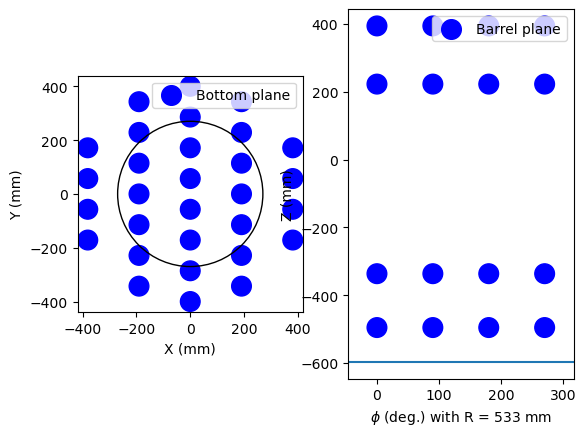

ValueError: s must be a scalar, or float array-like with the same size as x and y

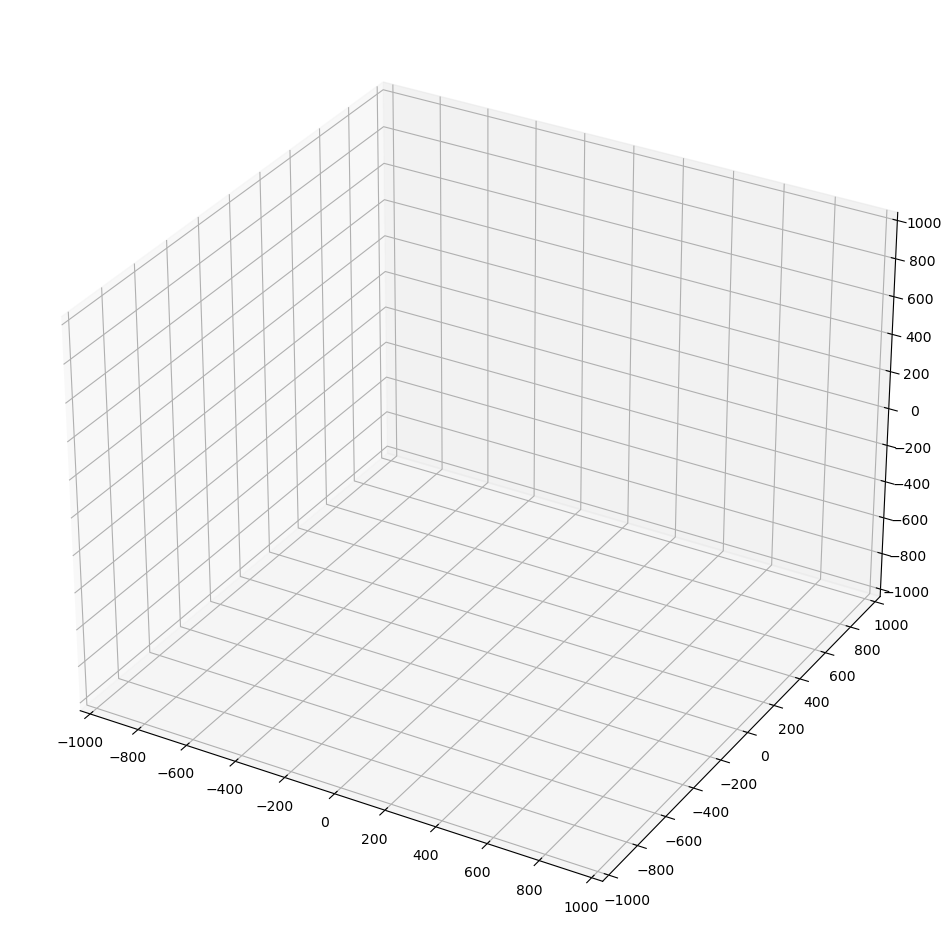

In [12]:
from sympy import plot_implicit
from sympy.abc import X, Y

event_start_time=-1
event_end_time=-1
# define path to your raw root file
#DATA_DIR='/home/guang/work/bnl1t/drop/src'
ch_string = ""
hodo_len = 20

for i in range(15):
    ch_string += "adc_b1_ch{} ".format(i+1)
for i in range(15):
    ch_string += "adc_b2_ch{} ".format(i)
for i in range(16):
    ch_string += "adc_b3_ch{} ".format(i)
for i in range(12):
    ch_string += "adc_b4_ch{} ".format(i)
    
#print (ch_string)    

#for word in ch_string.split():
#    print (word)
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid
    
def display_charge(chg, hchg):
    dis_x=[]
    dis_y=[]
    area=[]
    area2=[]
    area3=[]
    locx_bot = [381, 381, 381, 381, 
            190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 
            0, 0, 0, 0, 0, 0, 0, 0, 
           -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, -190.5,
           -381, -381, -381, -381,
               ]
    locy_bot = [-171.45, -57.15, 57.15, 171.45,
           -342.9, -228.6, -114.3, 0, 114.3, 228.6, 342.9,
           -400.05, -285.75, -171.45, -57.15,57.15, 171.45, 285.75, 400.05,
           -342.9, -228.6, -114.3, 0, 114.3, 228.6, 342.9,
           -171.45, -57.15, 57.15, 171.45]
    locx_side= [532.955,532.955,532.955,532.955,
                0,0,0,0, 0,0,0,0,
                -532.955, -532.955,-532.955,-532.955,
                354,354,354,
                354,354,354,
                -354,-354,-354,
                -354,-354,-354
               ]
    locy_side= [0,0,0,0,
                -532.955, -532.955,-532.955,-532.955,
                532.955,532.955,532.955,532.955,
                0,0,0,0,
                -354,-354,-354,
                354,354,354,
                -354,-354,-354,
                354,354,354]
    locz_side= [ 393.7, 222.25, -336.55, -495.3,
               393.7, 222.25, -336.55, -495.3,
               393.7, 222.25, -336.55, -495.3,
               393.7, 222.25, -336.55, -495.3,
               82, -58, -198,
               82, -58, -198,
               82, -58, -198,
               82, -58, -198,
               ]

    locx_3d = [ 381, 381, 381, 381, 
            190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 
            0, 0, 0, 0, 0, 0, 0, 0, 
           -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, -190.5,
           -381, -381, -381, -381, 
            532.955,532.955,532.955,532.955,
                0,0,0,0, 0,0,0,0,
                -532.955, -532.955,-532.955,-532.955,
                354,354,354,
                354,354,354,
                -354,-354,-354,
                -354,-354,-354]
    locy_3d = [-171.45, -57.15, 57.15, 171.45,
           -342.9, -228.6, -114.3, 0, 114.3, 228.6, 342.9,
           -400.05, -285.75, -171.45, -57.15,57.15, 171.45, 285.75, 400.05,
           -342.9, -228.6, -114.3, 0, 114.3, 228.6, 342.9,
           -171.45, -57.15, 57.15, 171.45,
            0,0,0,0,
                -532.955, -532.955,-532.955,-532.955,
                532.955,532.955,532.955,532.955,
                0,0,0,0,
                -354,-354,-354,
                354,354,354,
                -354,-354,-354,
                354,354,354]
    locz_3d = [ -641, -641, -641, -641,-641, -641,-641, -641,-641, -641,
               -641, -641,-641, -641,-641, -641,-641, -641,-641, -641,
               -641, -641,-641, -641,-641, -641,-641, -641,-641, -641,
                393.7, 222.25, -336.55, -495.3,
               393.7, 222.25, -336.55, -495.3,
               393.7, 222.25, -336.55, -495.3,
               393.7, 222.25, -336.55, -495.3,
               82, -58, -198,
               82, -58, -198,
               82, -58, -198,
                82, -58, -198,]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    #plt.rcParams['figure.figsize'] = [16, 4]
    print ('chg length ',len(chg))
    for i in range(len(chg)):
        if i < 30:
            area.append(chg[i]*50)
            area3.append(chg[i]*50)
        elif i < 46+12:
            if i>29 and i<34:
                dis_x.append(0)
            if i>33 and i<38:
                dis_x.append(270)
            if i>37 and i<42:
                dis_x.append(90)
            if i>41 and i<46:
                dis_x.append(180)
            if i>45 and i<49:
                dis_x.append(315)
            if i>48 and i<52:
                dis_x.append(45)
            if i>51 and i<55:
                dis_x.append(225)
            if i>54 and i<58:
                dis_x.append(135)
            dis_y.append(locz_side[i-30])
            area2.append(chg[i]*50)
            area3.append(chg[i]*50)
    print(len(locx_bot),' ',len(locy_bot),' ',len(area))
    print(len(dis_x),' ',len(dis_y),' ',len(area3))    
    ax1.scatter(locx_bot, locy_bot, s=area, c="Blue", alpha=1, label="Bottom plane")
    ax2.scatter(dis_x, dis_y, s=area2, c="Blue", alpha=1, label="Barrel plane")
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    ax2.set_xlabel("$\phi$ (deg.) with R = 533 mm")
    ax2.set_ylabel("Z (mm)")
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

    Drawing_uncolored_circle = plt.Circle( (0, 0 ),
                                          270 ,
                                          fill = False )
     
    ax1.set_aspect( 1 )
    ax1.add_artist( Drawing_uncolored_circle )

    linepos = -641 + 44.4
    plt.axline((-30, linepos), (300, linepos))
    plt.show()

    fig = plt.figure(figsize=(12,28))
    # syntax for 3-D projection
    #ax = Axes3D(fig)
    ax = plt.axes(projection ='3d')
     
    # defining axes
    z = np.linspace(0, 1, 100)
    x = z * np.sin(25 * z)
    y = z * np.cos(25 * z)
    c = x + y
    ax.set_xticks([-1000,-800,-600,-400,-200,0,200,400,600,800,1000])
    ax.set_yticks([-1000,-800,-600,-400,-200,0,200,400,600,800,1000])
    ax.set_zticks([-1000,-800,-600,-400,-200,0,200,400,600,800,1000])
    ax.axes.set_xlim3d(left=-1000, right=1000) 
    ax.axes.set_ylim3d(bottom=-1000, top=1000) 
    ax.axes.set_zlim3d(bottom=-1000, top=1000) 
    ax.scatter(locx_3d, locy_3d, locz_3d, s=area3, c = "Blue")
    Xc,Yc,Zc = data_for_cylinder_along_z(0,0,642,501)
    ax.plot_surface(Xc, Yc, Zc, alpha=0.3)

    i1 = -1;
    i2 = -1;
    i3 = -1;
    i4 = -1;
    for i in range(8):
        if (chg[i] > 0.5):
            i1 = i
    for i in range(8):
        if (chg[i+8] > 0.5):
            i2 = i
    for i in range(8):
        if (chg[i+16] > 0.5):
            i3 = i
    for i in range(8):
        if (chg[i+24] > 0.5):
            i4 = i
            
    #radius is 500.38 mm
    VecStart_x = (620-500.38) + (7-i2)*hodo_len + hodo_len/2.;
    VecStart_y = (500.38 - 490) + i1*hodo_len + hodo_len/2.;
    VecStart_z = 941;
    VecEnd_x = (500-500.38) + (7-i4)*hodo_len + hodo_len/2;
    VecEnd_y = (500.38 - 400) + i3*hodo_len + hodo_len/2;
    VecEnd_z = -941;
    ax.plot([VecStart_x, VecEnd_x], [VecStart_y,VecEnd_y],[VecStart_z,VecEnd_z], 'r--', linewidth=3) 
     
    # syntax for plotting
    ax.set_title('LY in 3D')
    plt.show()

evt_chg = 46*[4]
hodo_chg = []
display_charge(evt_chg, hodo_chg)

In [ ]:
def display_hodoscope(chg):

    #f, (ax1) = plt.subplots(1, 1, figsize=(10,5))
    plt.subplot(1,2,1)
    plt.rcParams['figure.figsize'] = [10, 4]
    barlist=plt.bar([1,2,3,4,5,6,7,8], [8,8,8,8,8,8,8,8], alpha = 0.3)
    for i in range(8):
        if (chg[i] > 0.5):
            barlist[i].set_color('r')
        else:
            barlist[i].set_color('blue')
    #plt.show()

    barlist2=plt.barh([1,2,3,4,5,6,7,8], [9,9,9,9,9,9,9,9], alpha = 0.3)
    for i in range(8):
        if (chg[i+8] > 0.5):
            barlist2[i].set_color('r')
        else:
            barlist2[i].set_color('blue')
    #fig, ax = plt.subplots()
    #ax.barh(x, width = y)
    #plt.show()

    plt.subplot(1,2,2)
    barlist3=plt.barh([1,2,3,4,5,6,7,8], [8,8,8,8,8,8,8,8], alpha = 0.3)
    for i in range(8):
        if (chg[i+16] > 0.5):
            barlist3[i].set_color('r')
        else:
            barlist3[i].set_color('blue')

    barlist4=plt.bar([1,2,3,4,5,6,7,8], [9,9,9,9,9,9,9,9], alpha = 0.3)
    for i in range(8):
        if (chg[i+24] > 0.5):
            barlist4[i].set_color('r')
        else:
            barlist4[i].set_color('blue')
    plt.show()


In [13]:
dp.fig_height=10
dp.fig_width=20
schn = [[]*i for i in range(97)]
h_hodo = [[]*i for i in range(4)]
ichn = 0
hevt = 0
print('starting')

starting


event  2699


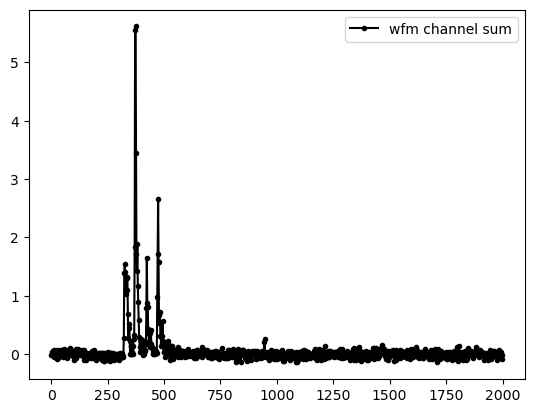

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  374   5.614475161323453
event  2700


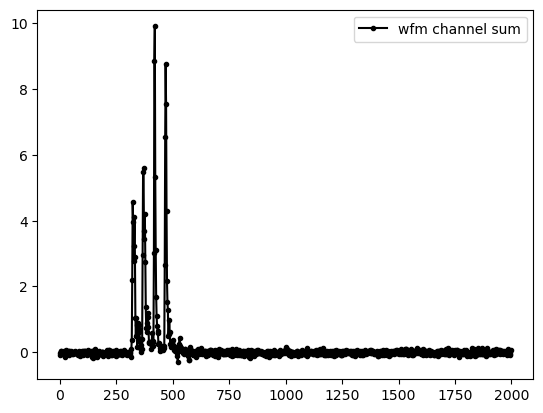

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  420   9.906122826476476
event  2701


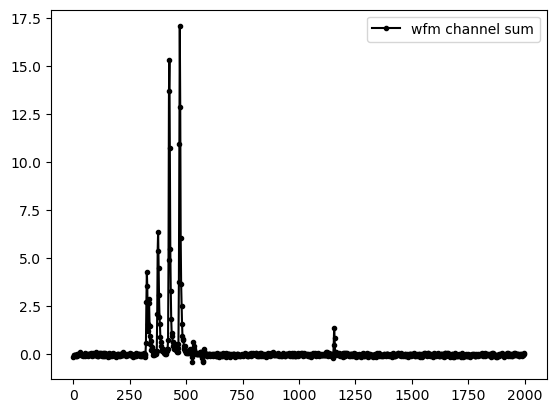

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   17.051226293901856
event  2702


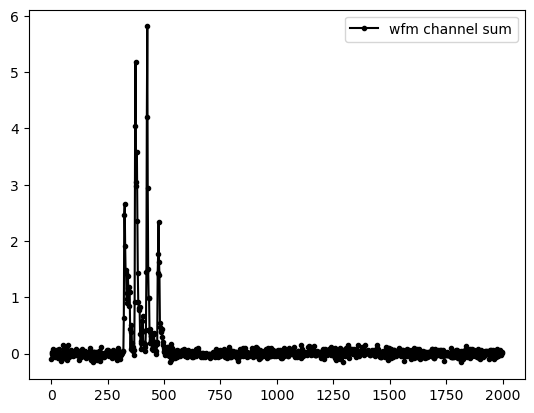

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  426   5.811082737735895
event  2703


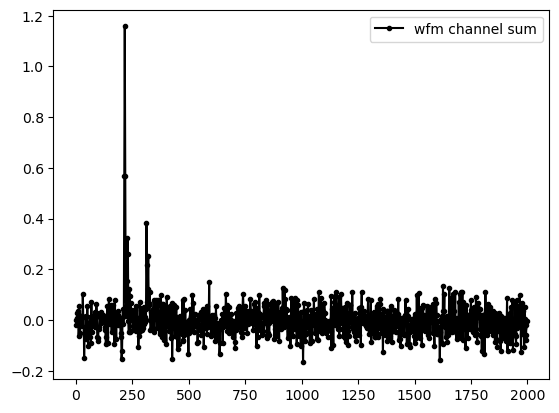

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  216   1.1577400226378471
event  2704


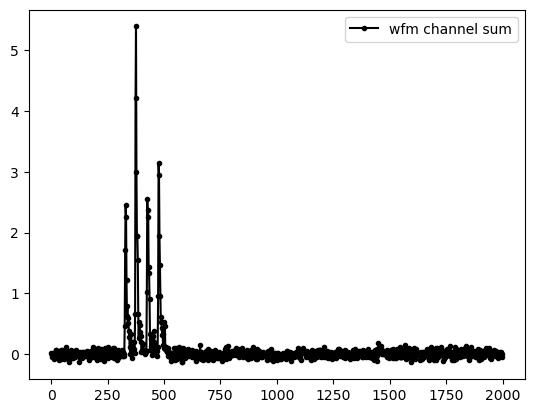

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  376   5.391503467393986
event  2705


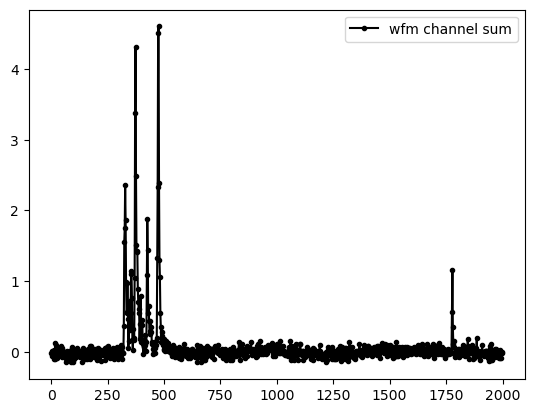

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  476   4.6005238362983345
event  2706


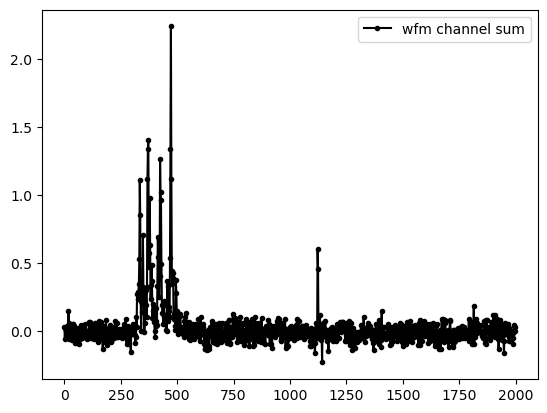

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   2.2379570122652024
event  2707


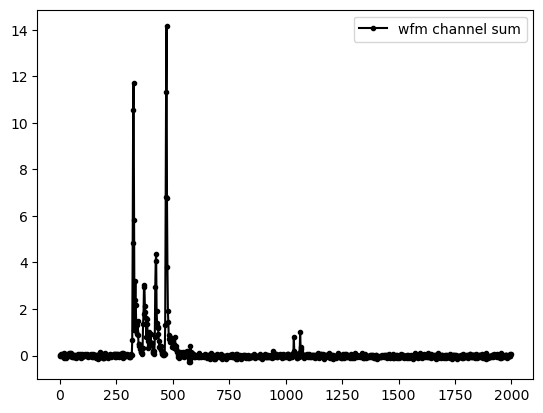

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   14.140923590066043
event  2708


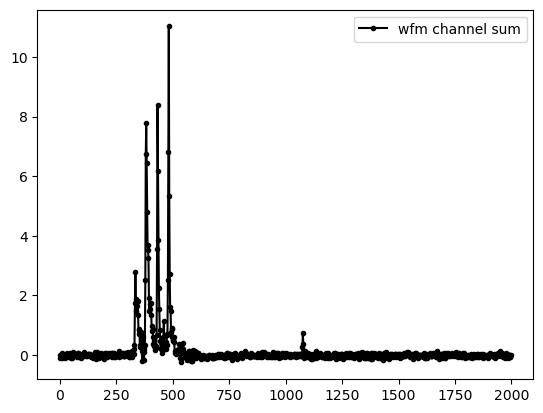

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  482   11.022824141943673
event  2709


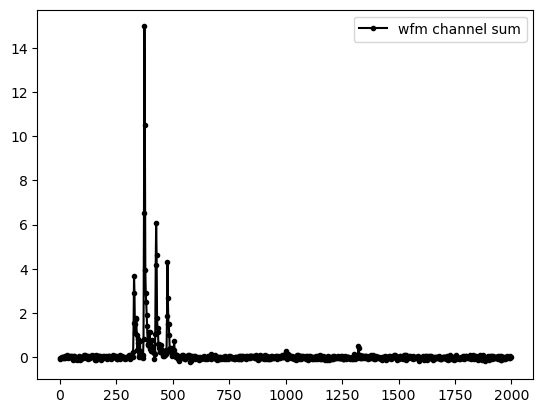

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  374   14.964998770044216
event  2710


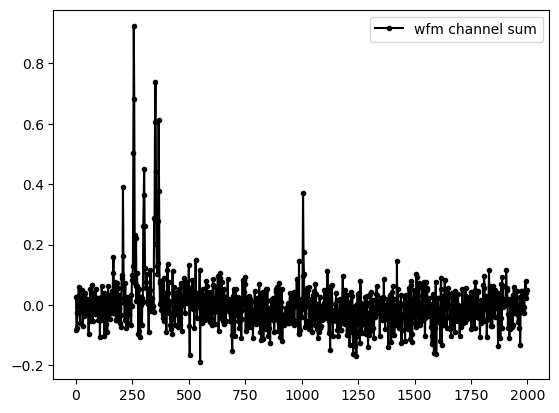

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  256   0.9217530014524479
event  2711


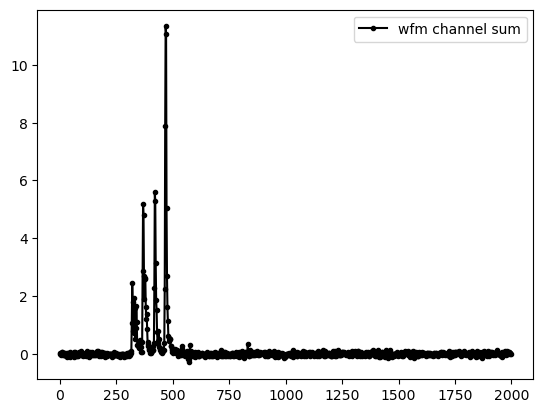

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  468   11.335253148676713
event  2712


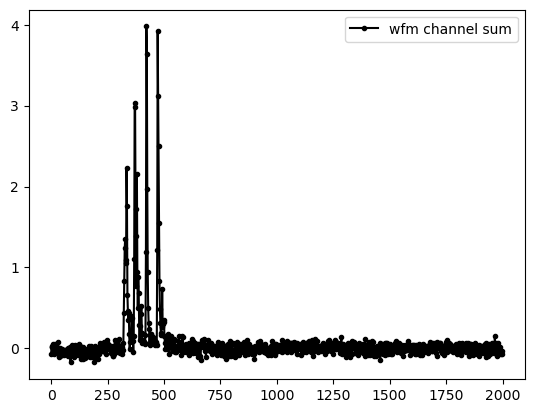

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  422   3.9783884750548077
event  2713


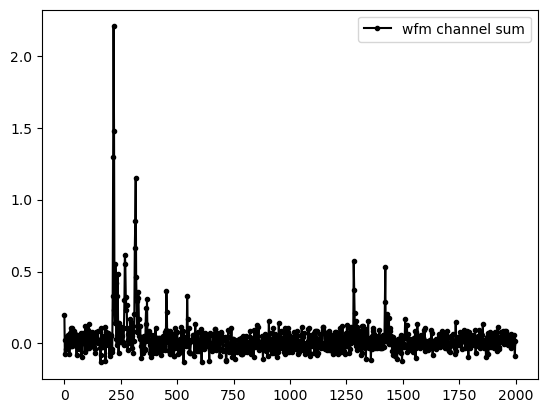

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  218   2.2043130766070145
event  2714


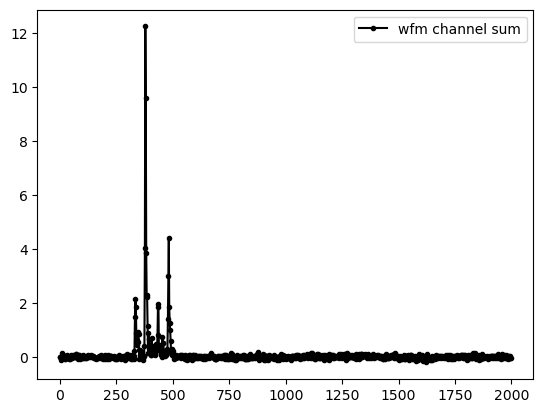

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  378   12.245850903498967
event  2715


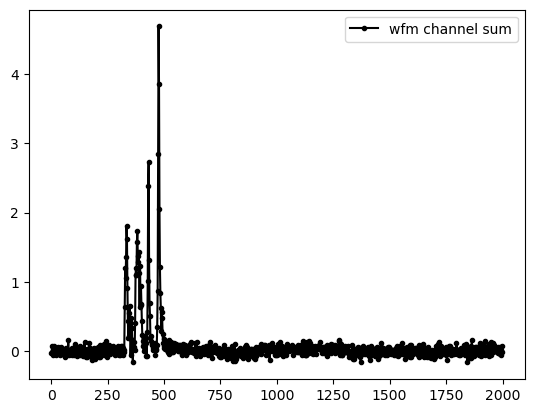

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  476   4.692434732792165
event  2716


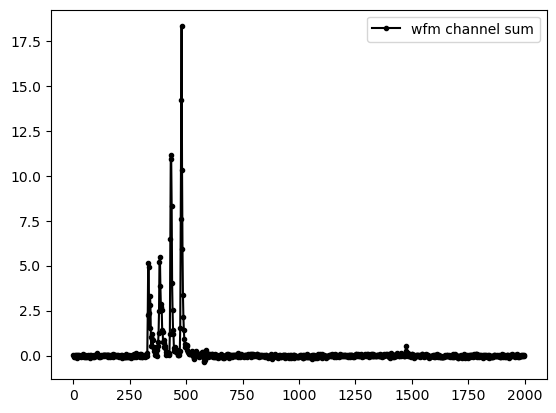

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  480   18.30303339836636
event  2717


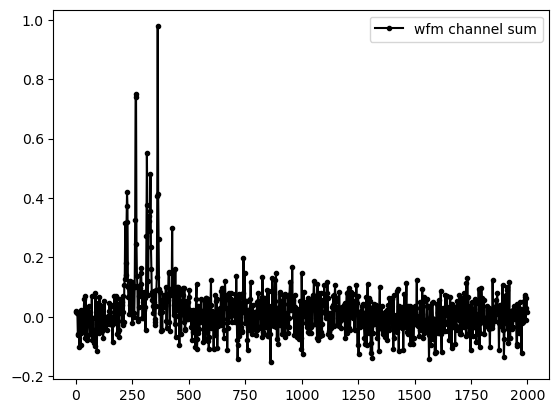

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  362   0.9773995752366221
event  2718


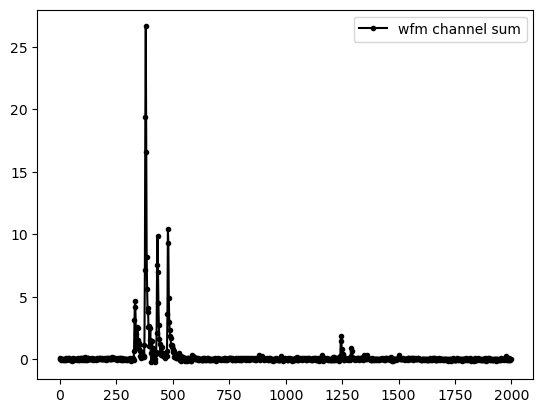

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  380   26.621619981636183
event  2719


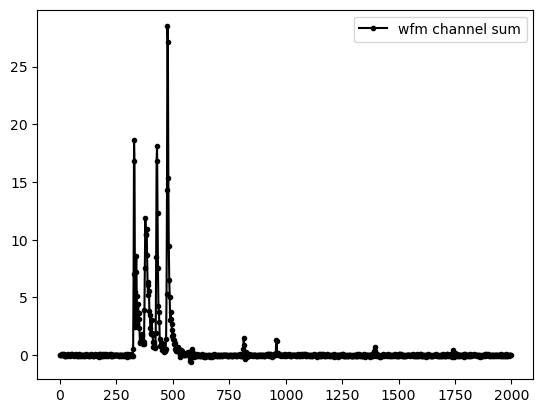

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  476   28.48081115966551
event  2720


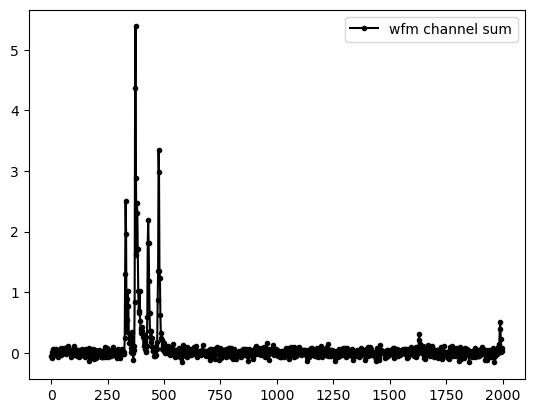

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  374   5.385862700229821
event  2721


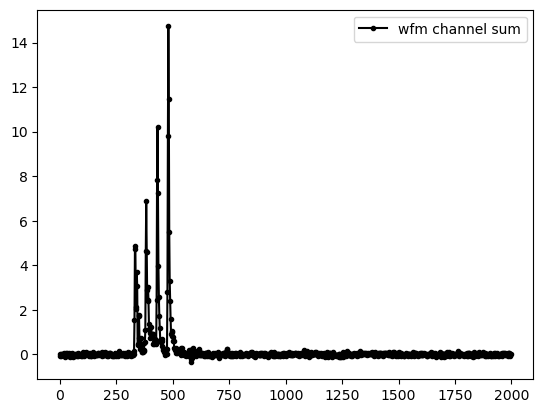

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  480   14.7210093405046
event  2722


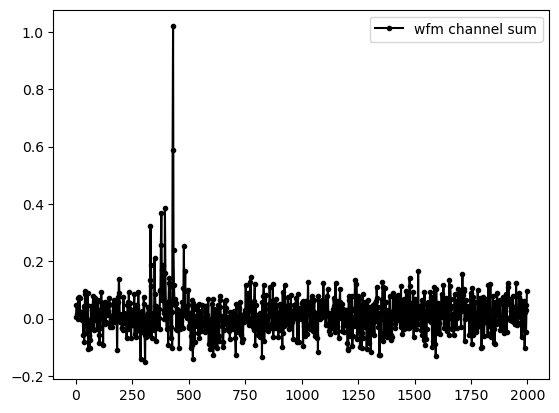

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  430   1.0190514824463648
event  2723


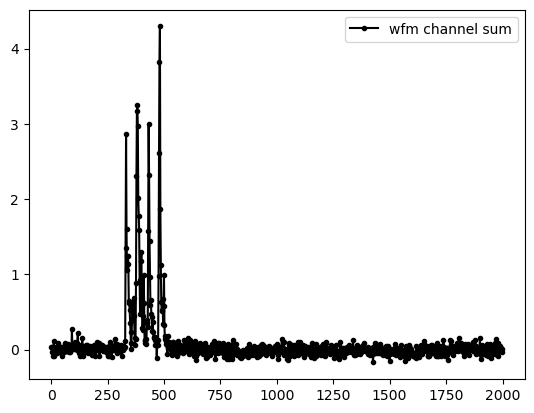

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  482   4.292979467896514
event  2724


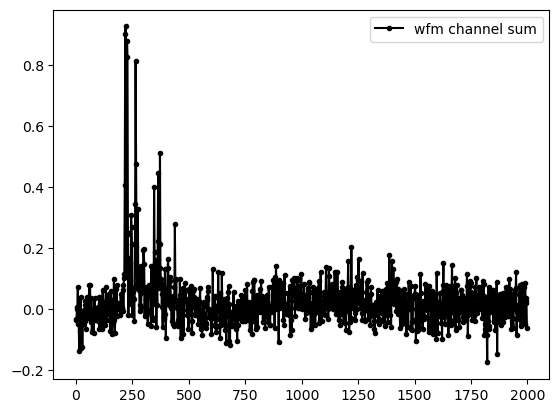

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  220   0.9276118931111039
event  2725


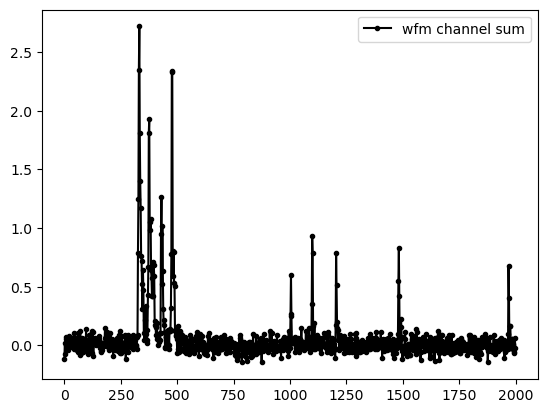

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  332   2.718106275497589
event  2726


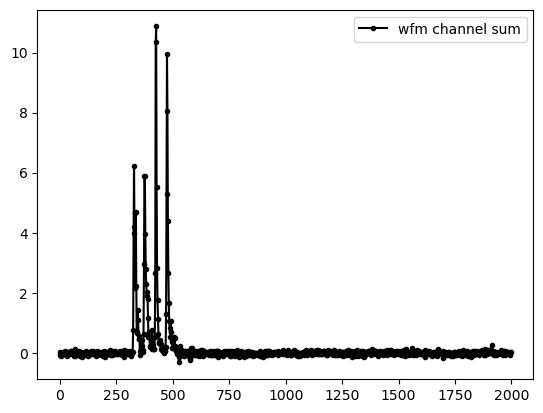

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  426   10.869071291059125
event  2727


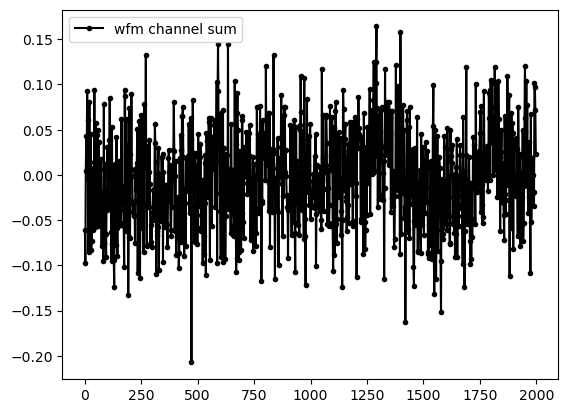

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  1292   0.16418023570396895
event  2728


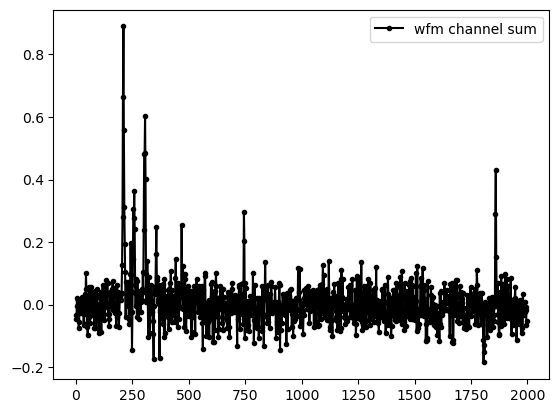

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  210   0.8895717601005361
event  2729


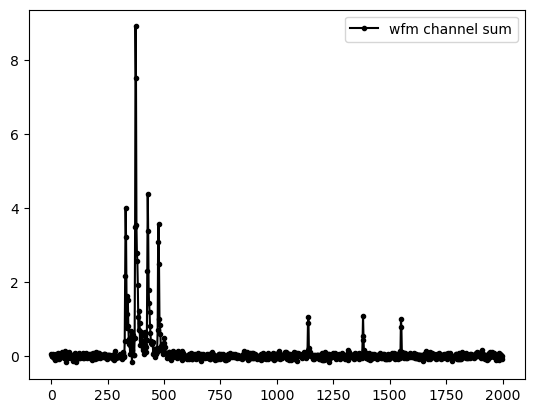

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  374   8.921148429668111
event  2730


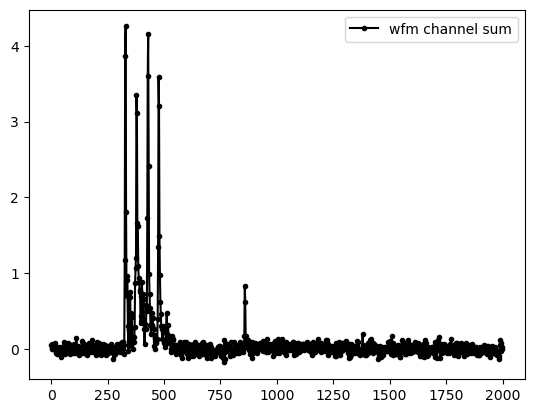

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  330   4.2541695732847495
event  2731


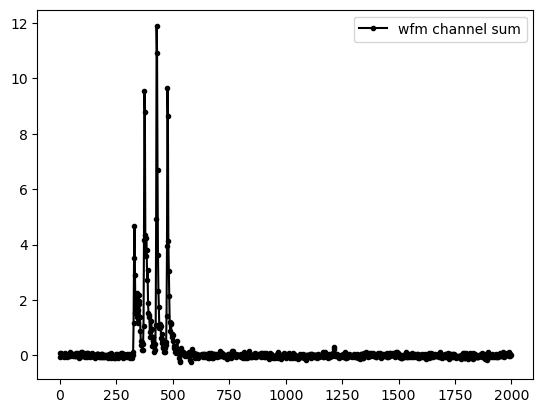

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  428   11.873003489973899
event  2732


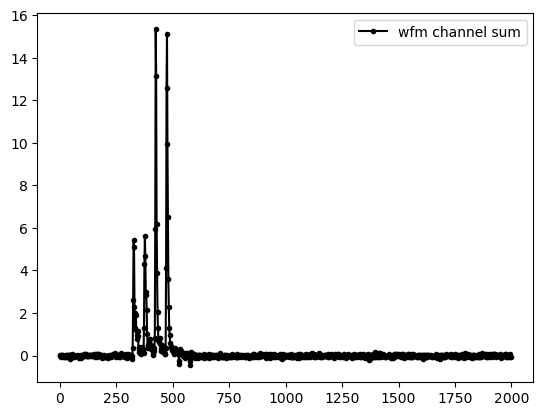

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  424   15.324120094846904
event  2733


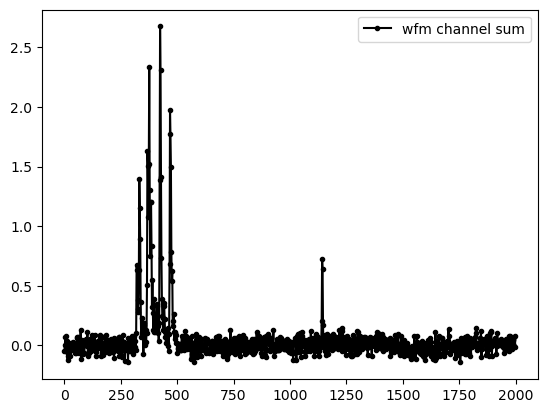

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  424   2.6762718866173083
event  2734


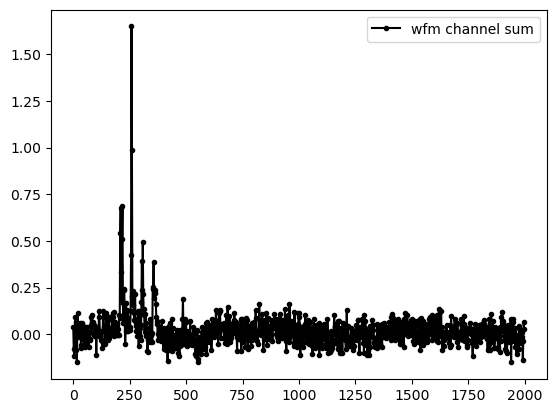

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  258   1.6480281088052056
event  2735


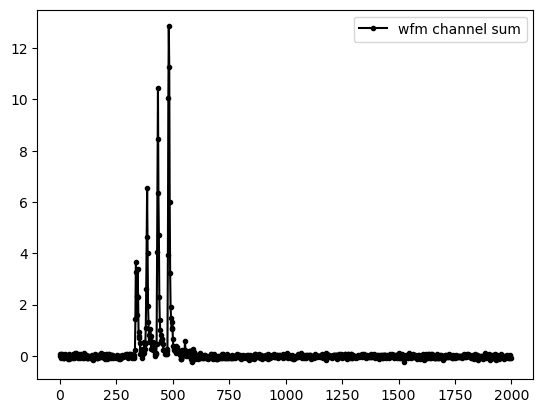

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  482   12.841589045172094
event  2736


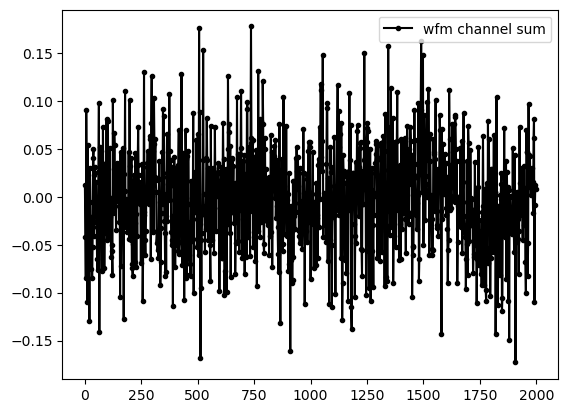

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  736   0.17795587456002585
event  2737


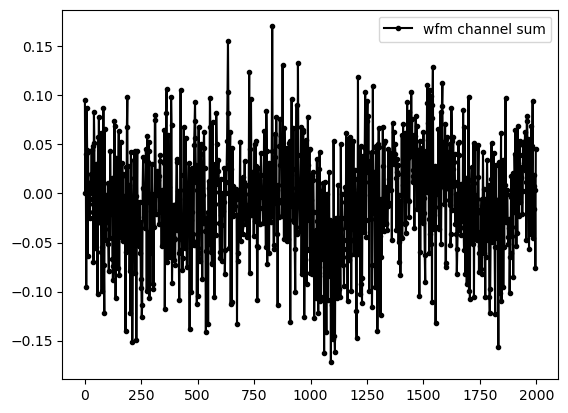

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  830   0.17029954086341642
event  2738


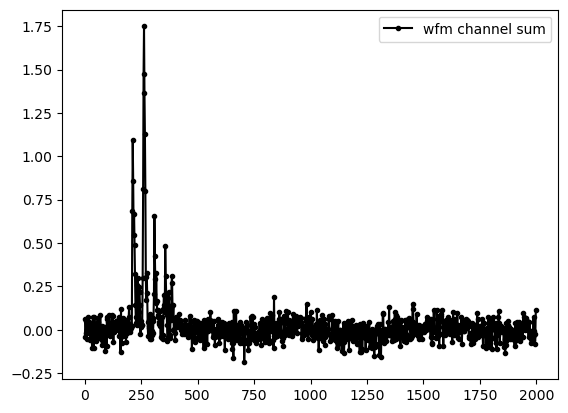

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  262   1.7483435915349141
event  2739


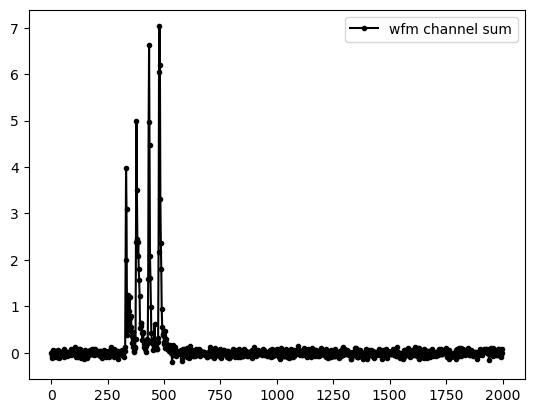

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  480   7.027562455651224
event  2740


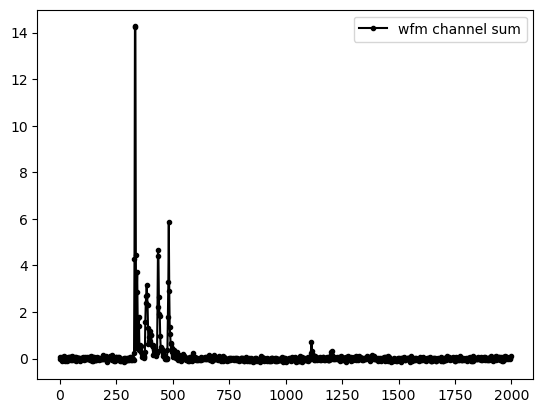

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  334   14.261613373369636
event  2741


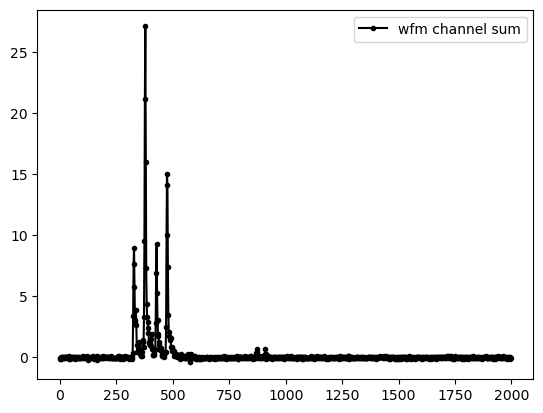

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  378   27.11503977677564
event  2742


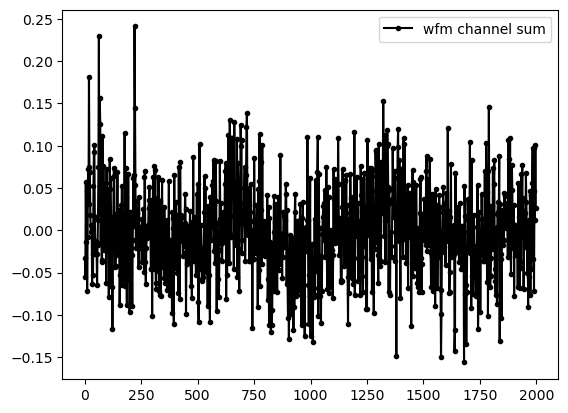

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  220   0.2410344935931784
event  2743


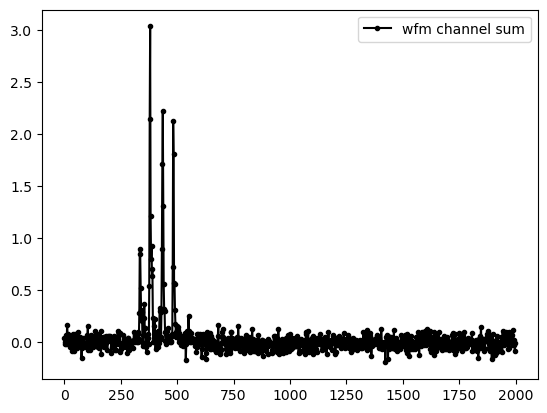

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  380   3.037163258567711
event  2744


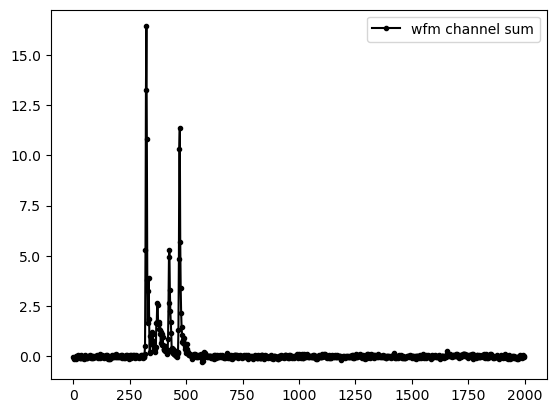

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  324   16.42704607481106
event  2745


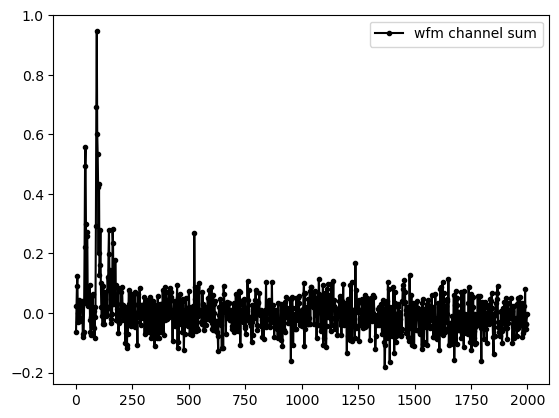

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  92   0.9453885670471976
event  2746


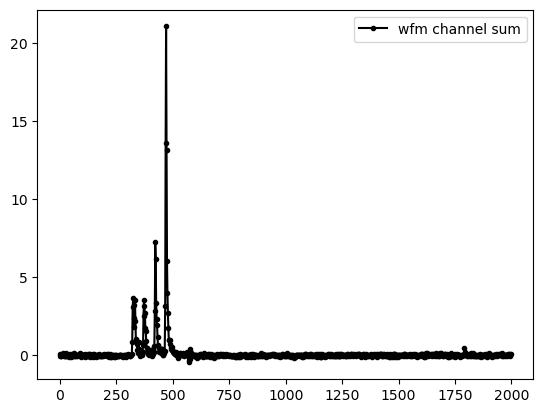

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  470   21.06624576811646
event  2747


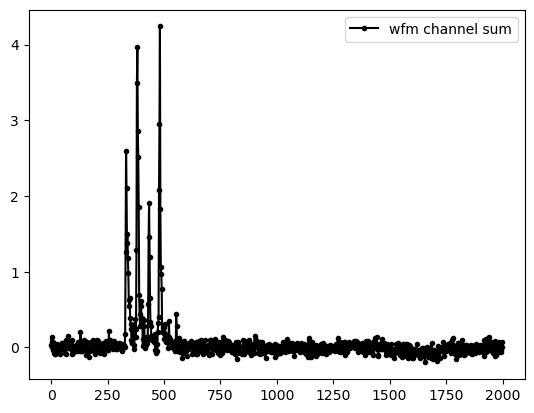

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  482   4.238041135554641
event  2748


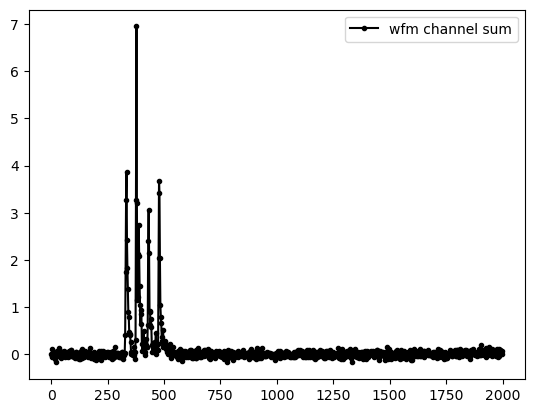

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  378   6.94736726644471
event  2749


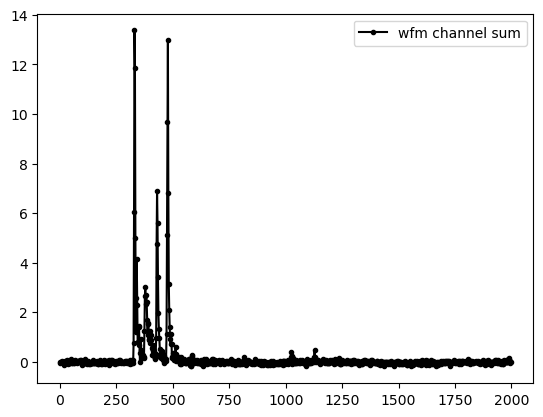

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  330   13.367216327673836
event  2750


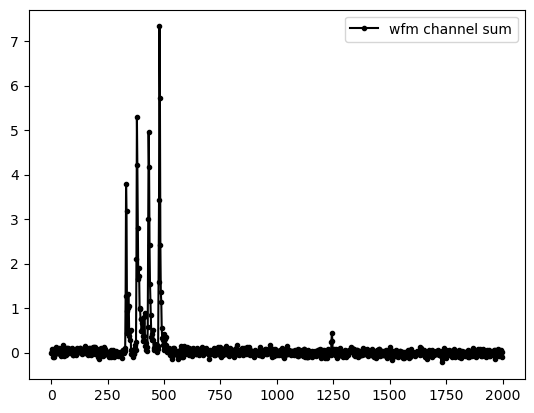

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  480   7.330736142179545
event  2751


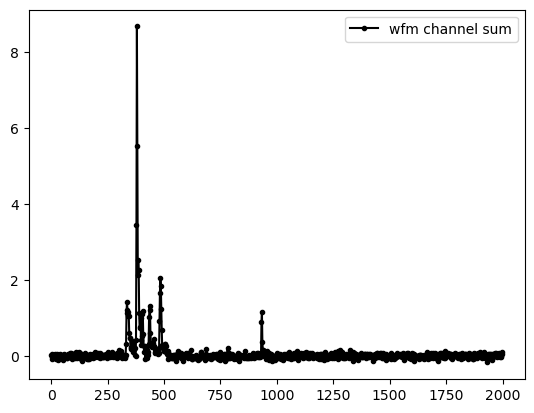

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  380   8.676536786555387
event  2752


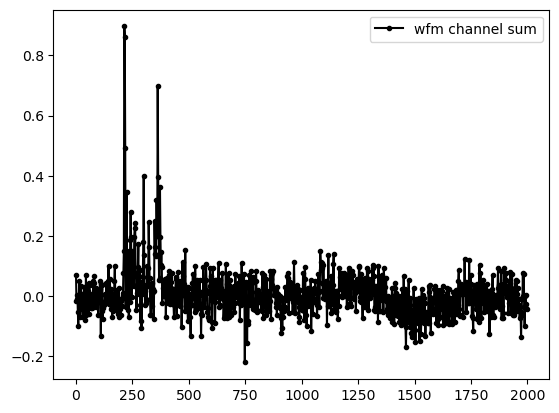

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  214   0.8960206027045396
event  2753


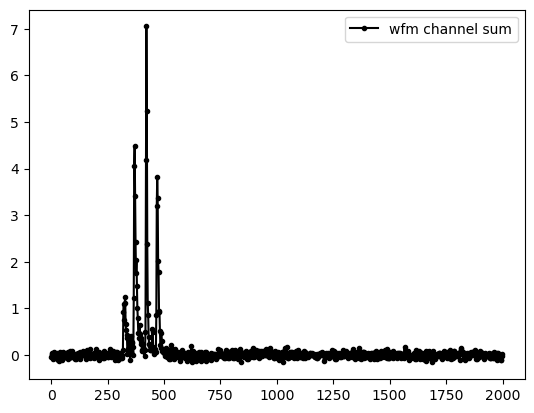

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  422   7.050021578493546
event  2754


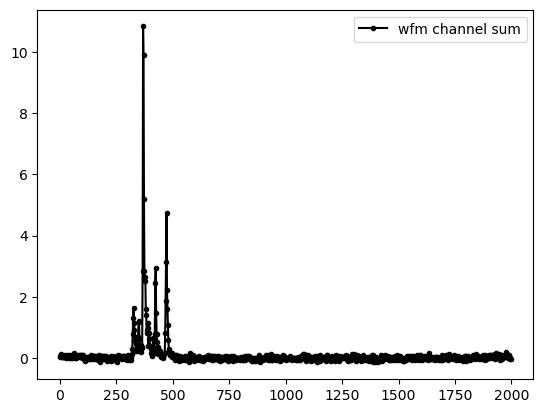

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  368   10.832182767462559
event  2755


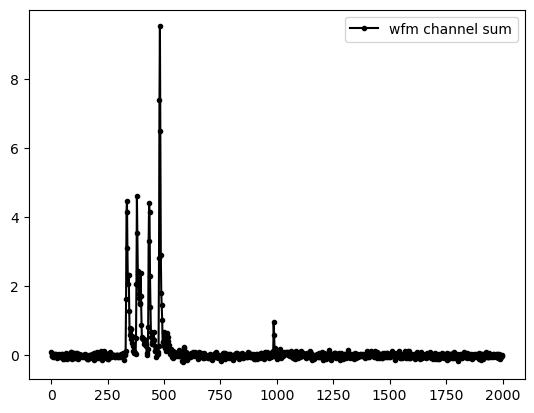

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  482   9.513329107069916
event  2756


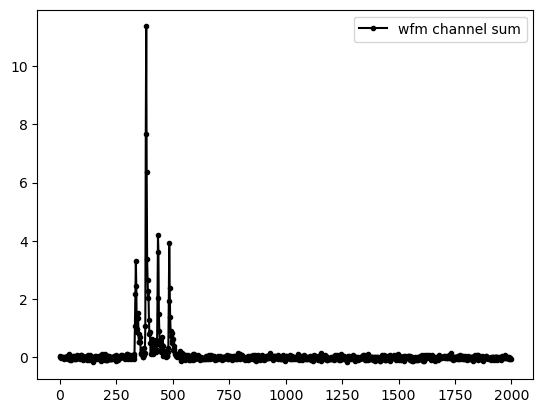

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  382   11.369181677669651
event  2757


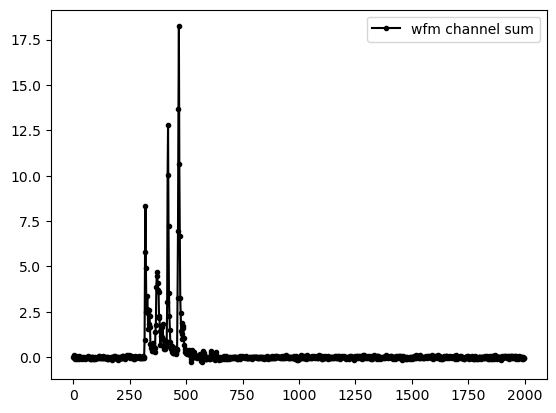

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  468   18.22430304677296
event  2758


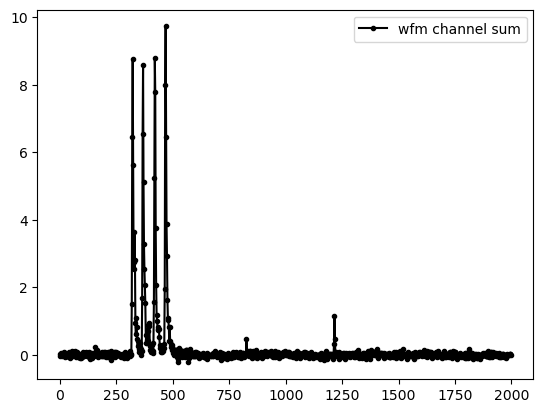

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  468   9.732256336741711
event  2759


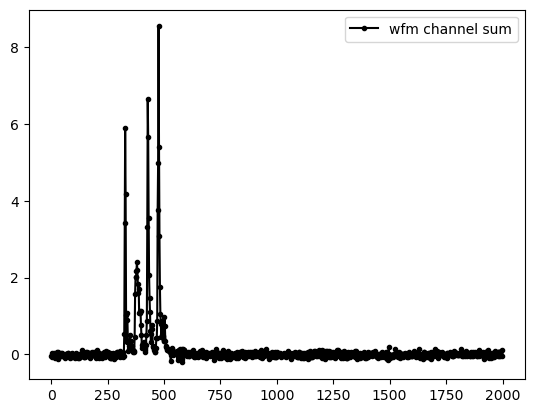

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  476   8.538251287405249
event  2760


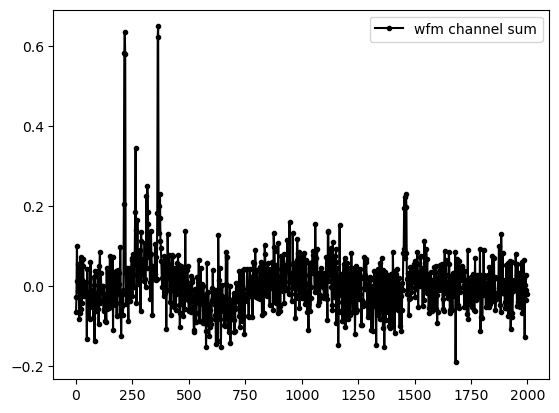

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  364   0.648433714938094
event  2761


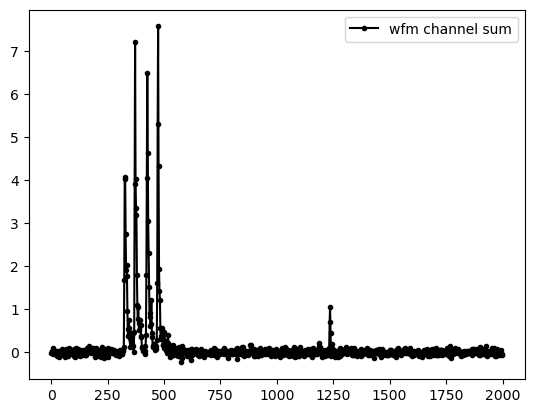

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   7.579696265278972
event  2762


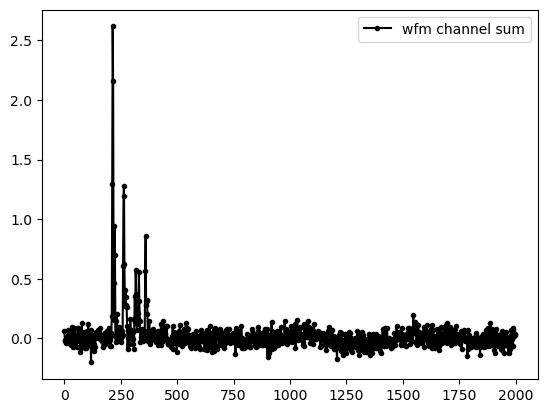

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  214   2.6167606950367057
event  2763


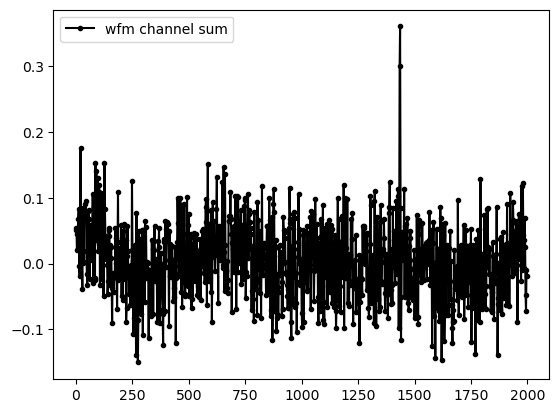

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  1436   0.3604137418734079
event  2764


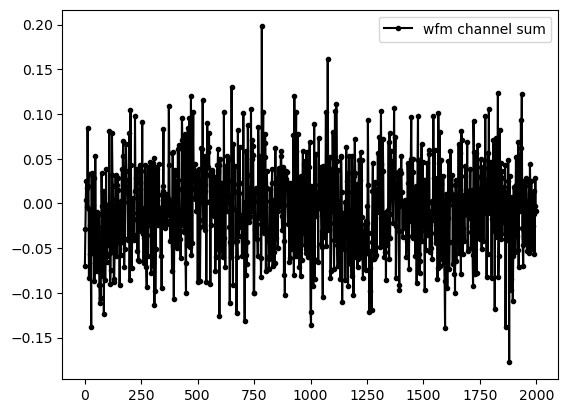

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  784   0.1979645141658975
event  2765


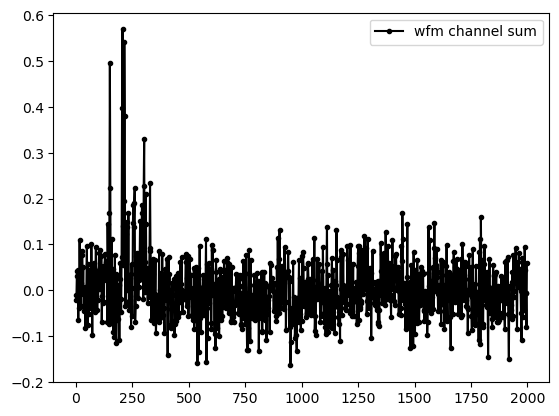

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  206   0.5688880432536723
event  2766


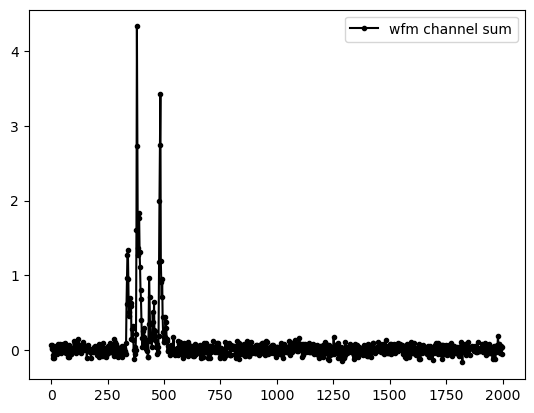

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  380   4.332474283193136
event  2767


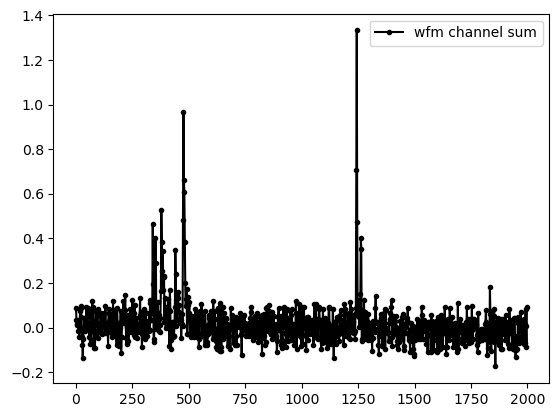

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  1244   1.332163644227255
event  2768


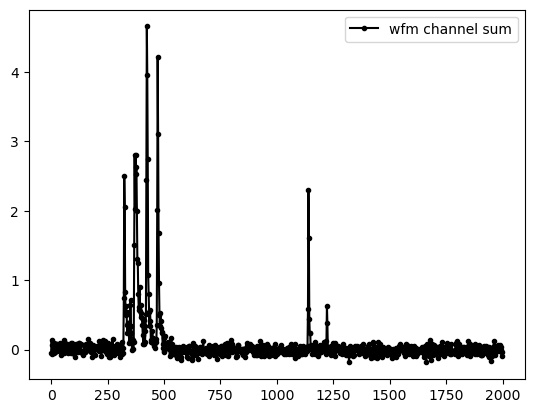

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  424   4.652732638027219
event  2769


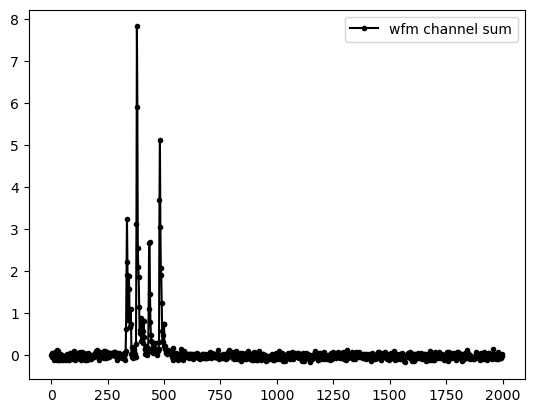

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  380   7.832194194119297
event  2770


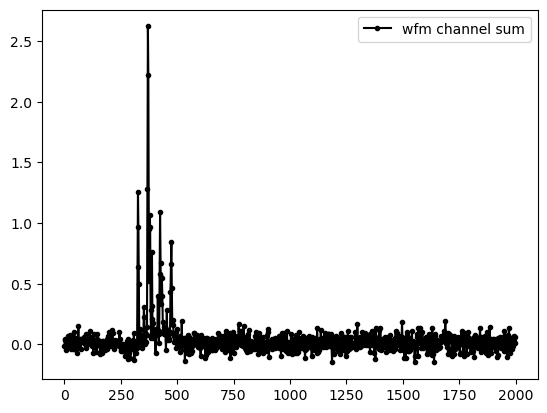

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  370   2.6220412697546367
event  2771


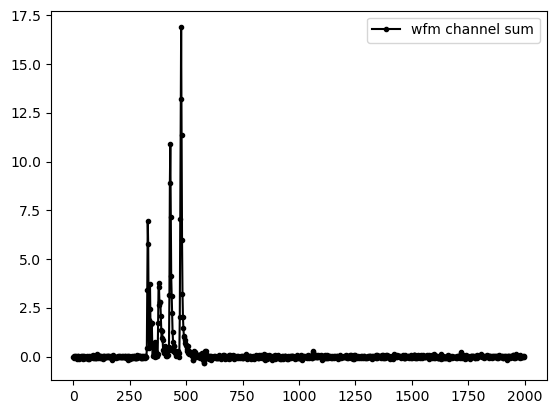

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  478   16.883830493600964
event  2772


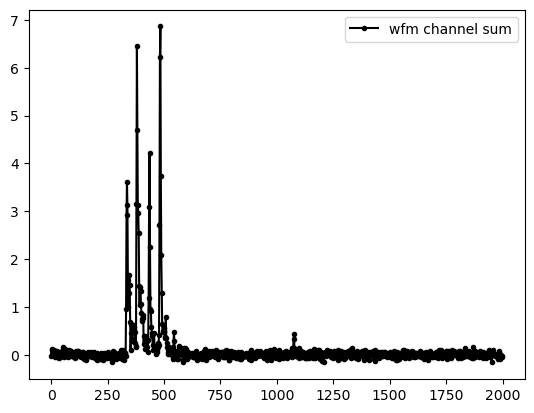

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  484   6.864638346347077
event  2773


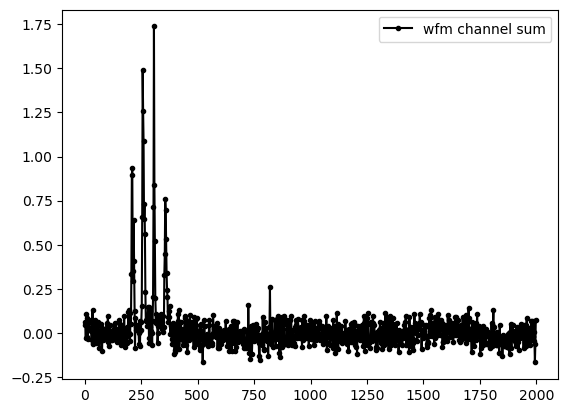

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  306   1.7376748984907093
event  2774


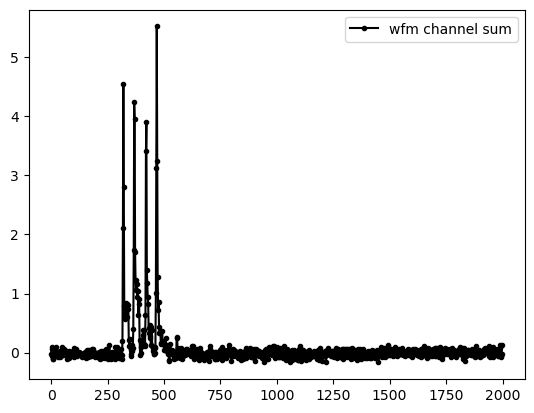

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  468   5.521781210227701
event  2775


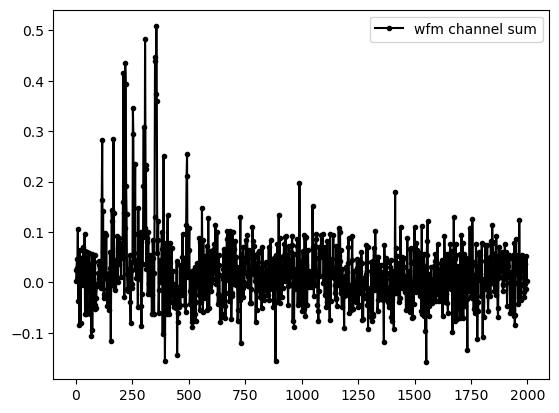

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  356   0.5075505438249878
event  2776


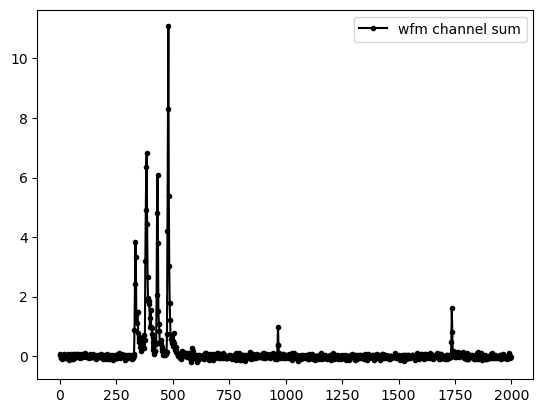

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  480   11.071804131749092
event  2777


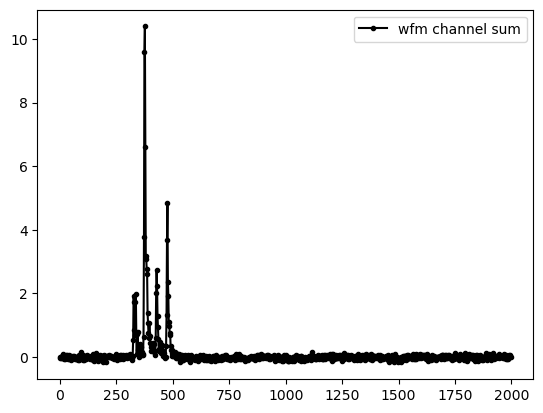

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  376   10.39369244983656
event  2778


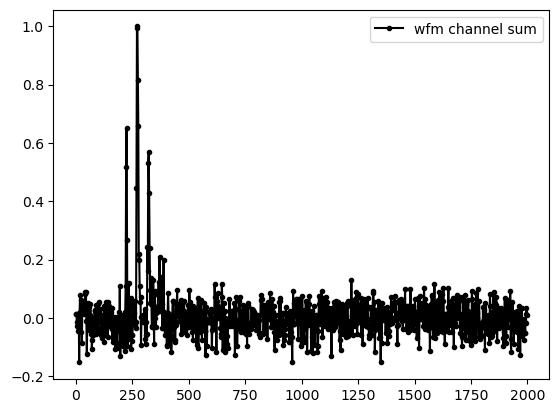

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  272   0.9994902033448259
event  2779


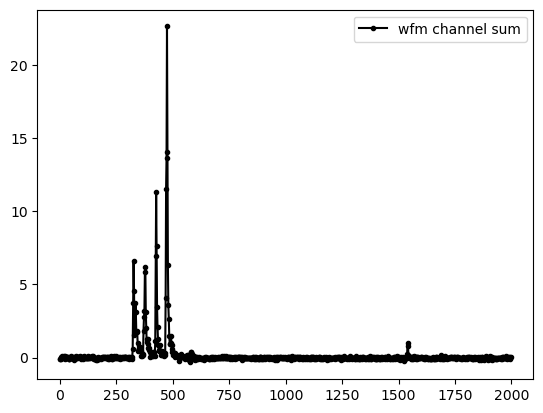

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   22.6086070437898
event  2780


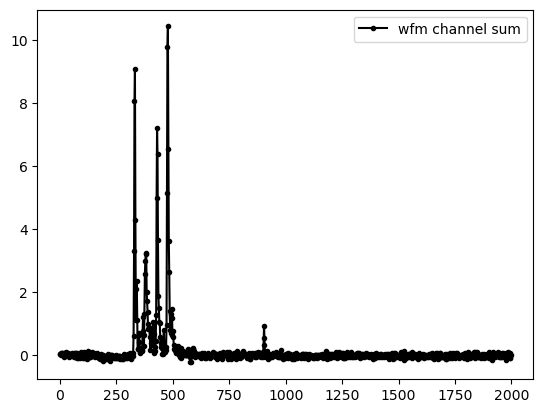

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  478   10.430778364133335
event  2781


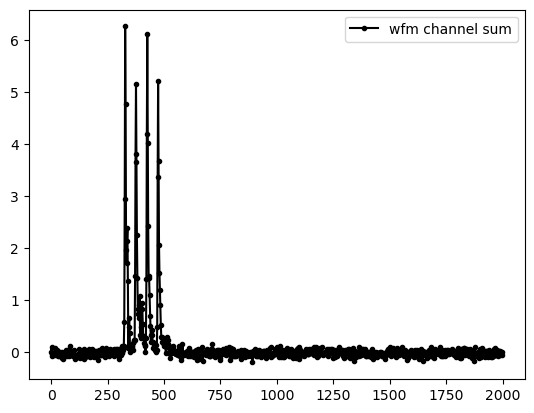

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  328   6.258492940628964
event  2782


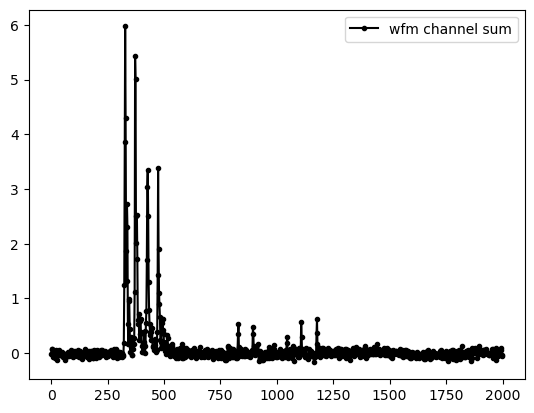

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  328   5.970248701746885
event  2783
Info: your wanted events are not found.
Hint: event_id is in this range [2699, 12700]
event  2784


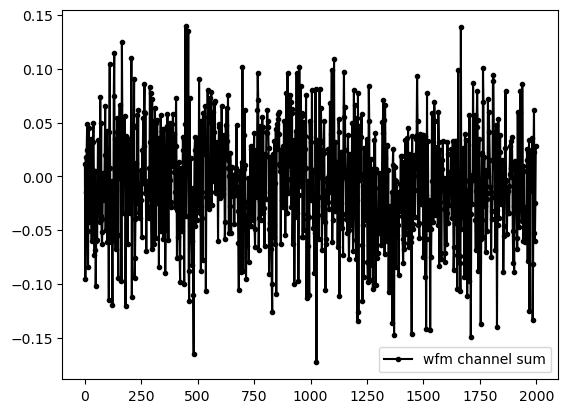

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  446   0.13929729289218581
event  2785


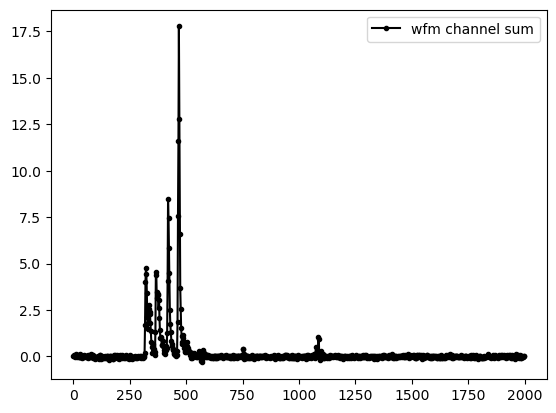

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  468   17.76115654116689
event  2786


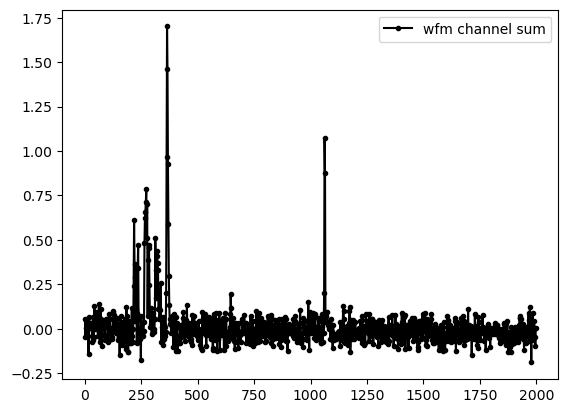

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  364   1.7011405422456007
event  2787


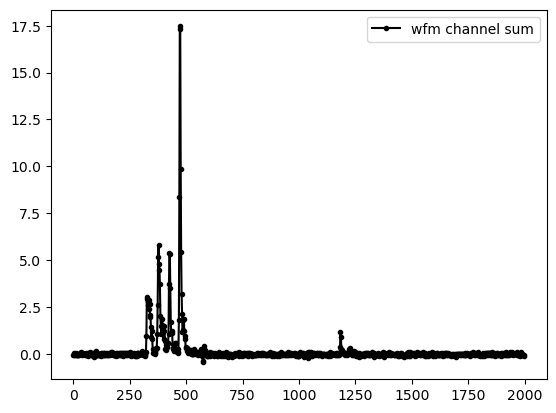

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   17.460345272481977
event  2788


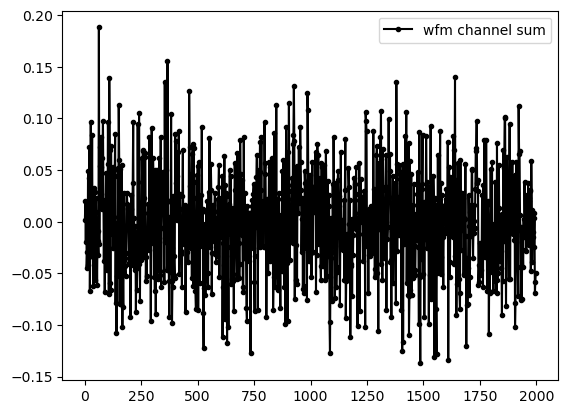

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  62   0.18806665581149068
event  2789


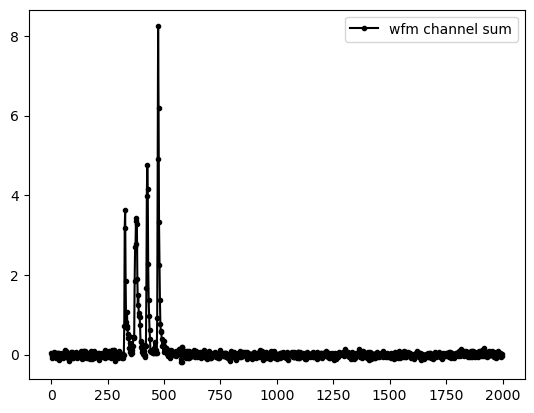

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   8.23655128316337
event  2790


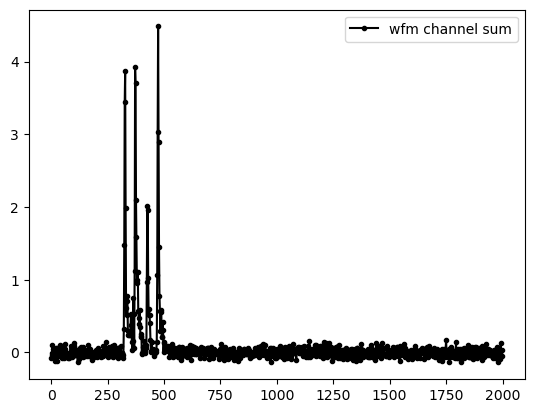

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   4.483335790848579
event  2791


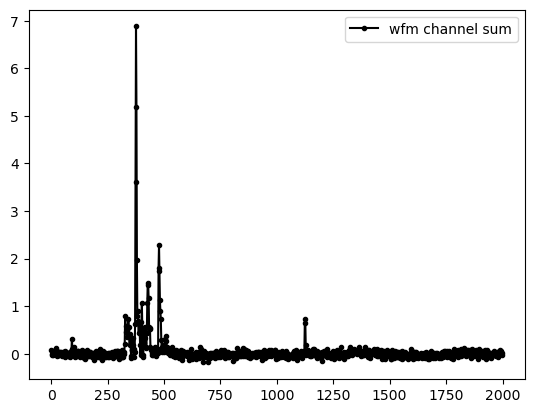

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  376   6.878491046997325
event  2792


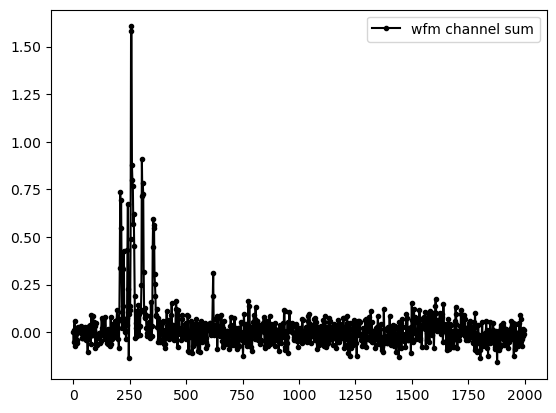

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  258   1.60610023270859
event  2793


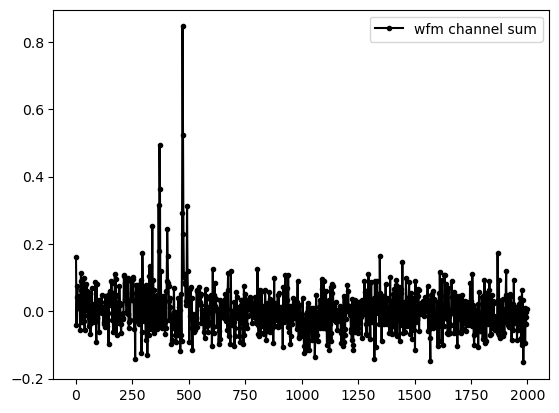

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   0.8459947308499111
event  2794


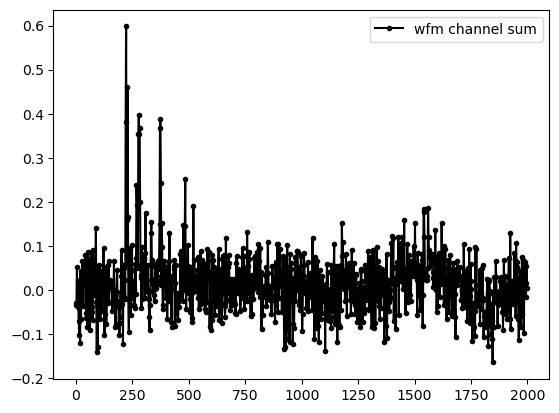

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  222   0.5979573479824751
event  2795


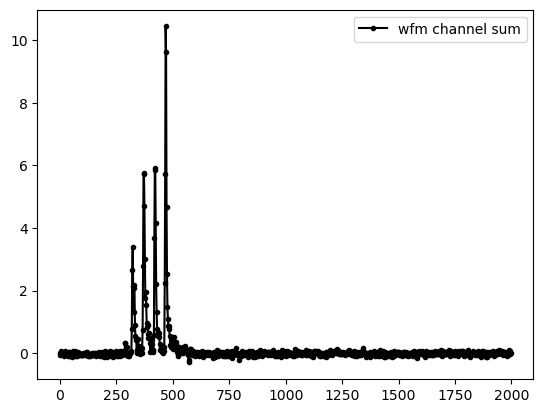

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  468   10.438095706221832
event  2796


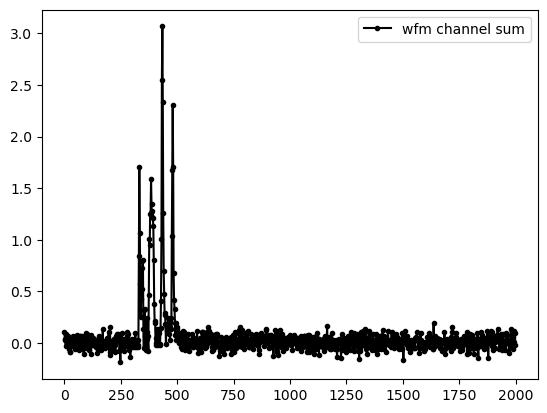

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  434   3.066572575368468
event  2797


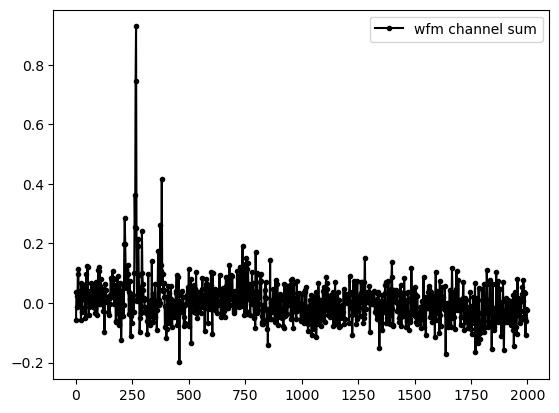

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  266   0.9286512706420887
event  2798


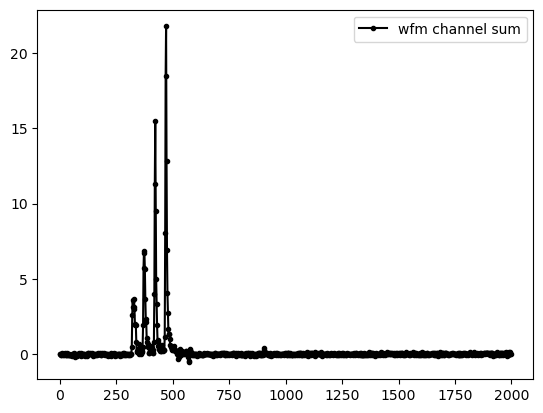

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  470   21.778902177510666
event  2799


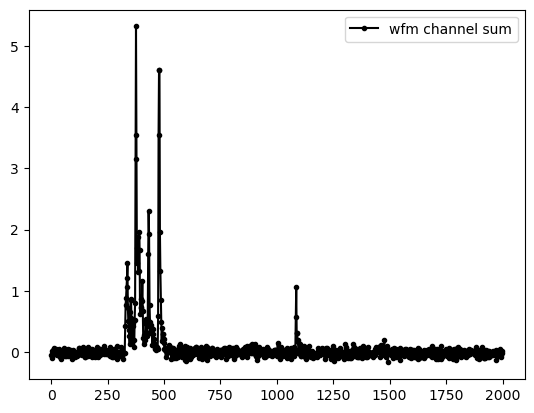

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  376   5.314998418316771
event  2800


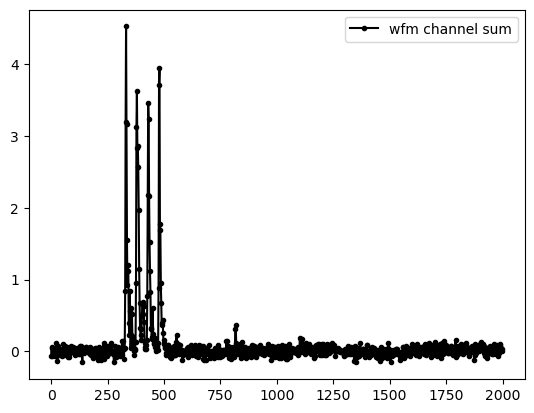

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  332   4.528996214532276
event  2801


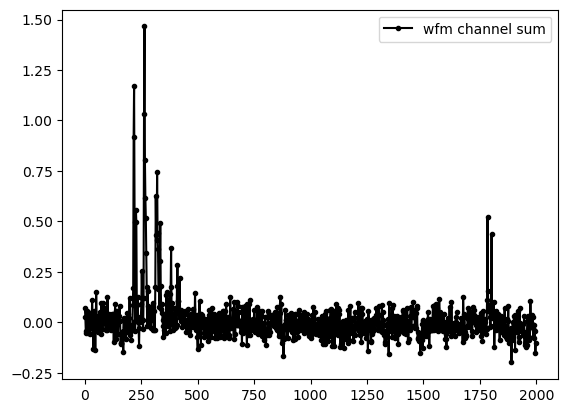

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  264   1.4655550351080693
event  2802


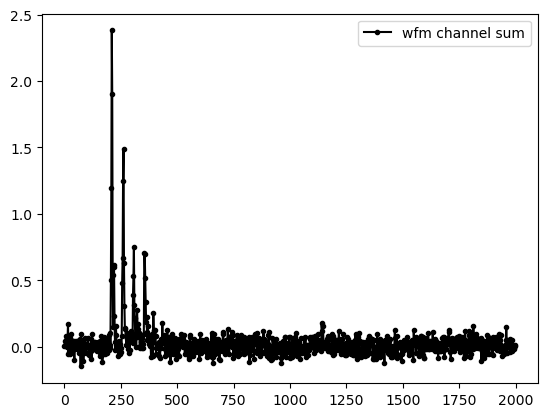

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  210   2.3799438156671666
event  2803


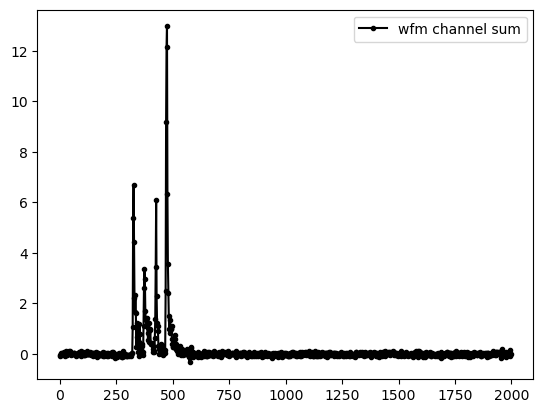

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   12.965941202930377
event  2804


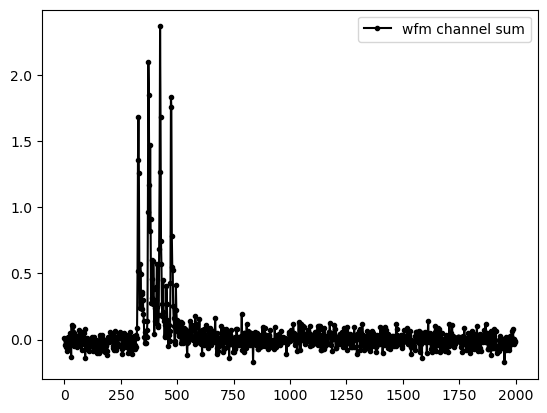

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  424   2.366506847098121
event  2805


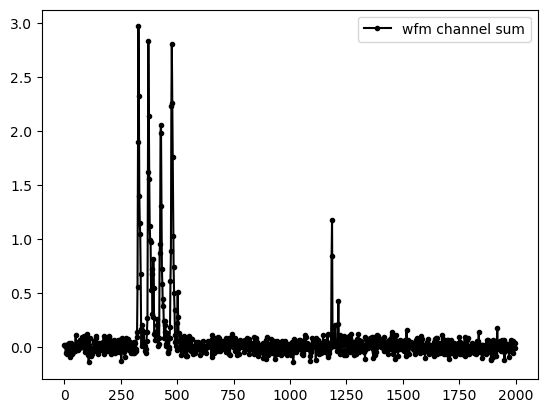

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  328   2.9702112103097673
event  2806


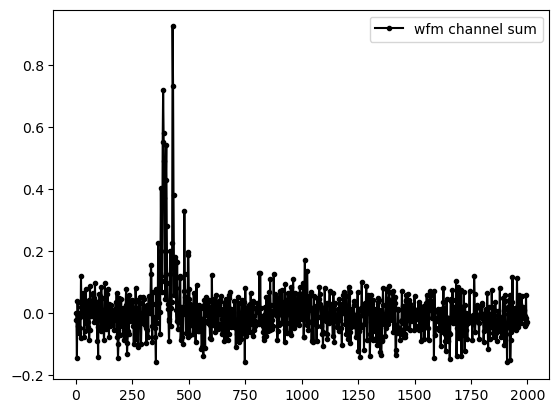

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  428   0.9254578500159197
event  2807


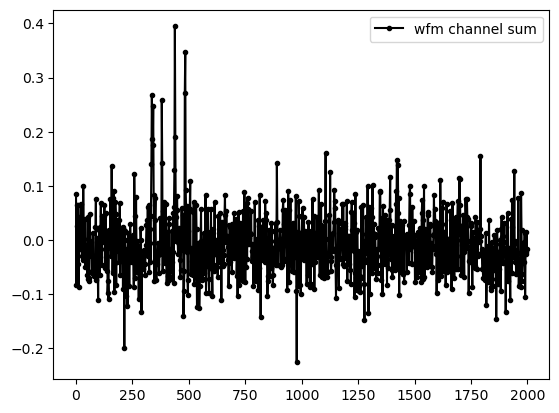

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  438   0.3944238055329961
event  2808


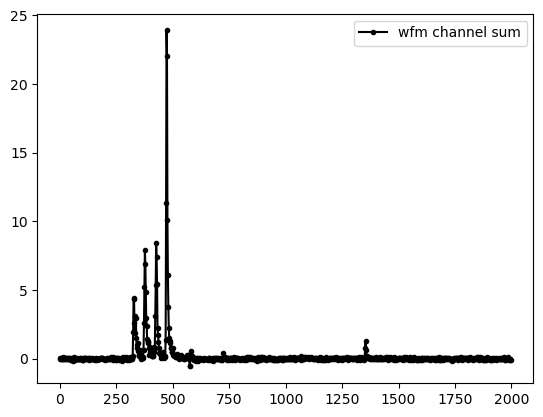

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   23.896841495017945
event  2809


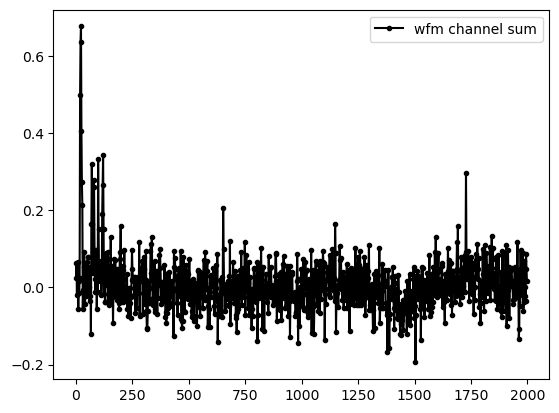

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  22   0.6764248940189953
event  2810


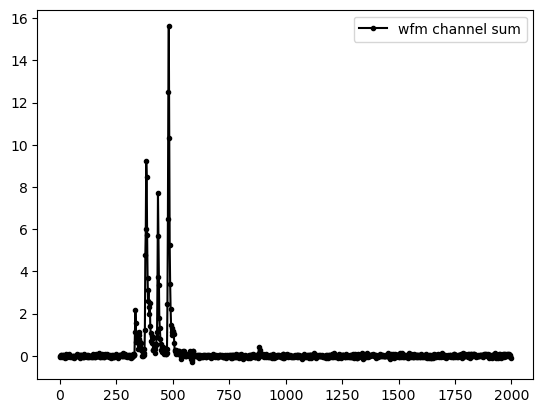

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  482   15.60925073348614
event  2811


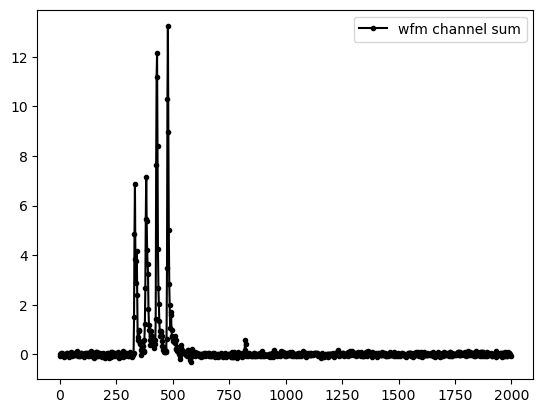

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  478   13.222556833570618
event  2812


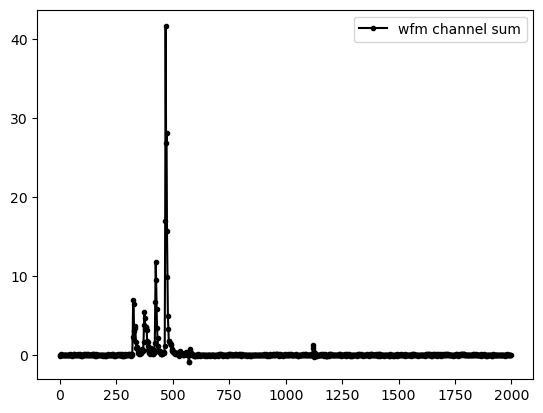

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  468   41.54638543725167
event  2813


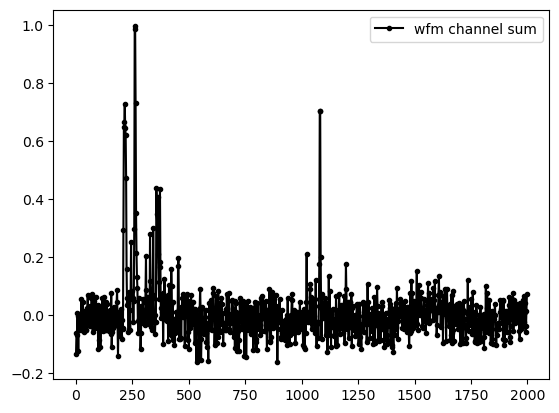

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  262   0.993995300406869
event  2814


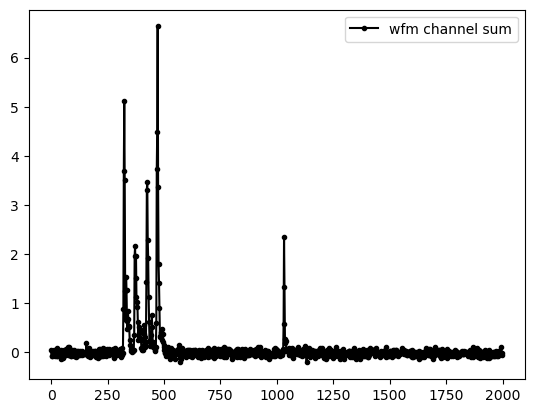

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   6.631628149411871
event  2815


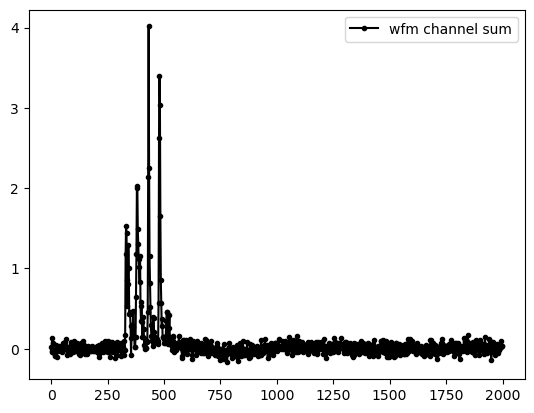

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  432   4.013337066905933
event  2816


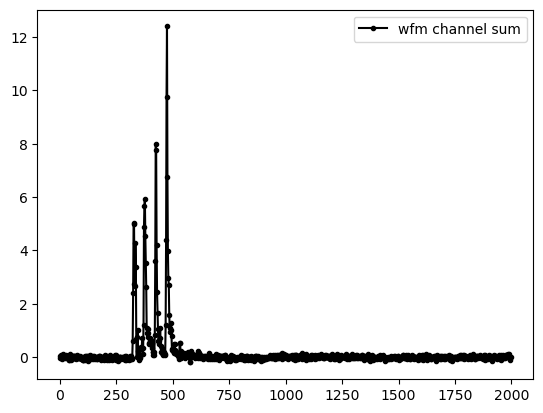

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   12.394182369957072
event  2817


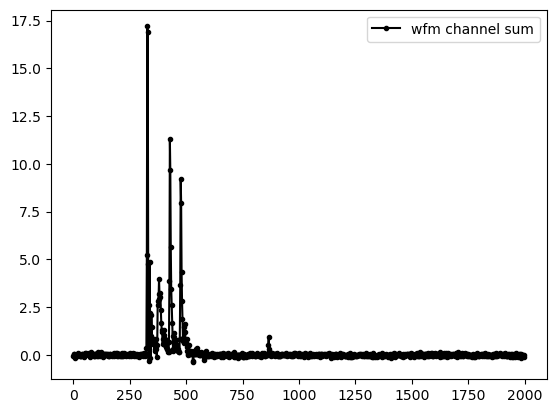

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  328   17.19278222893185
event  2818


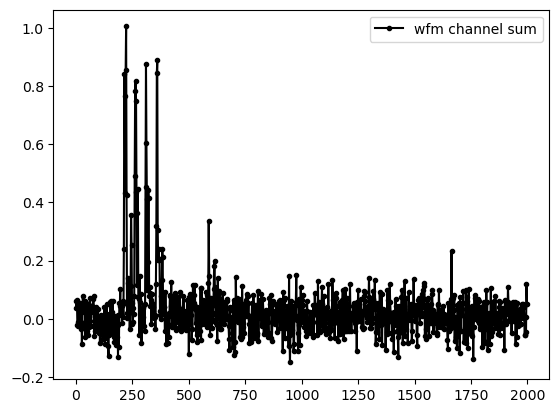

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  222   1.004693268401059
event  2819


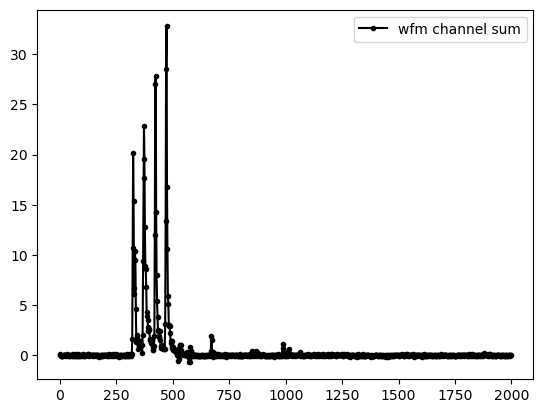

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   32.76182755339081
event  2820


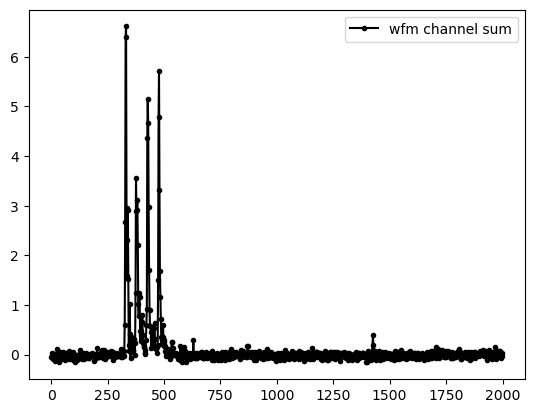

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  332   6.6098805556531515
event  2821


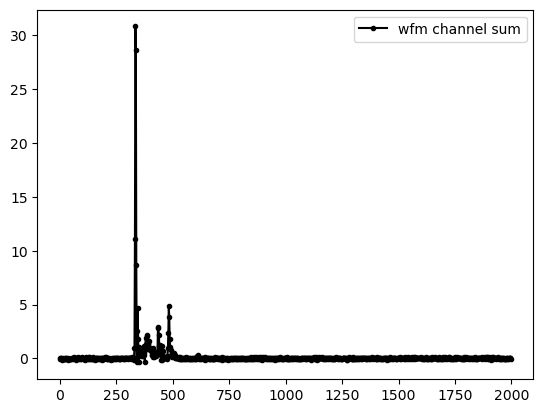

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  334   30.82995862341133
event  2822


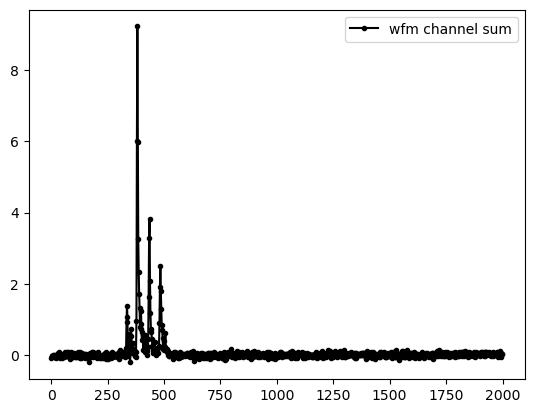

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  382   9.224602844487002
event  2823


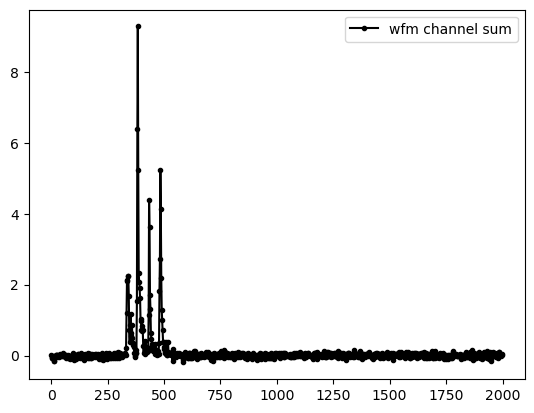

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  384   9.273731005291571
event  2824


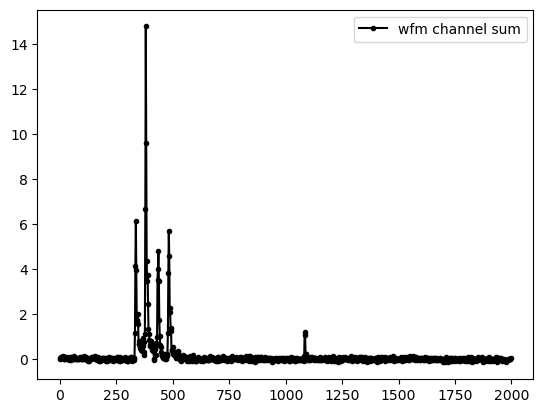

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  380   14.774852831190758
event  2825


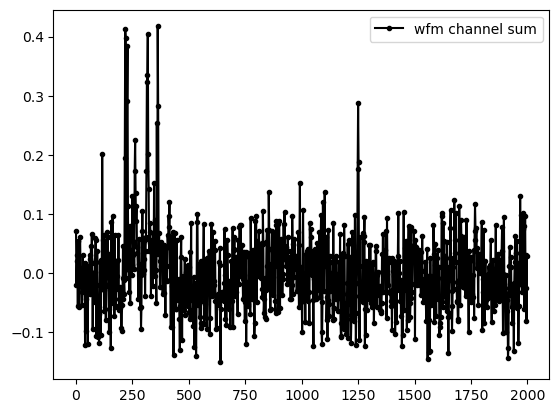

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  362   0.4171548647717135
event  2826


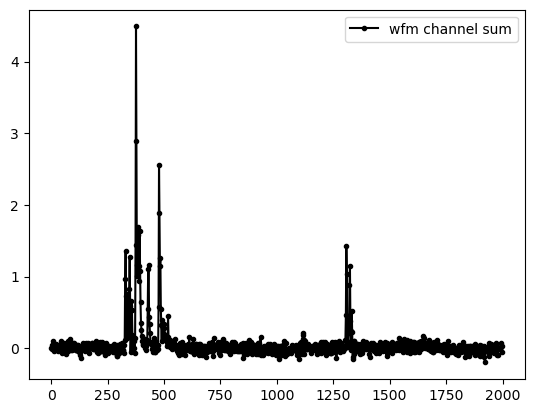

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  376   4.490379893793218
event  2827


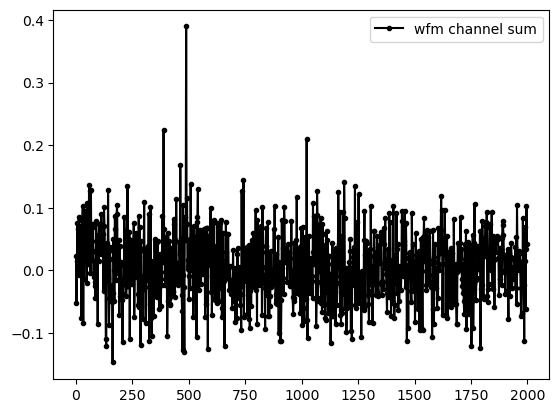

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  488   0.38959163800794405
event  2828


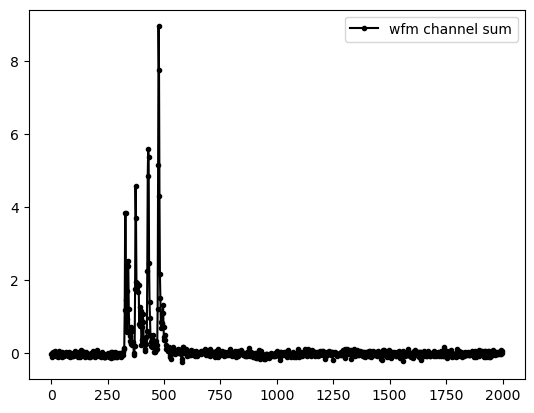

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  476   8.958933735093835
event  2829


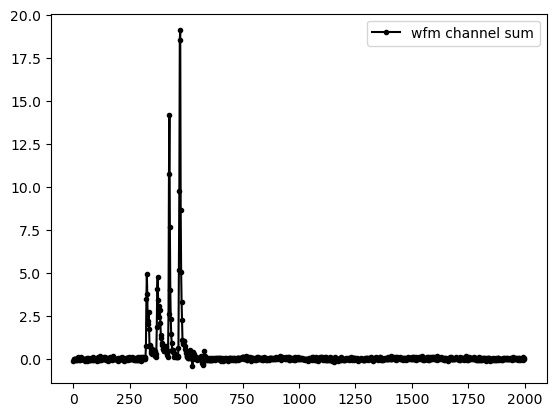

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   19.100727212812522
event  2830


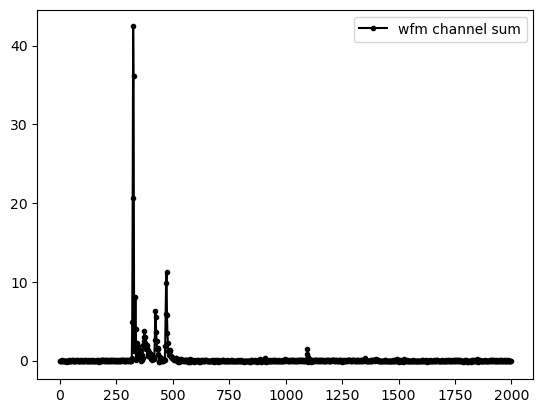

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  324   42.41657567865305
event  2831


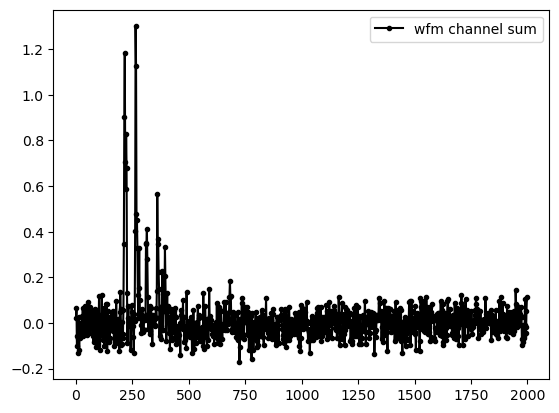

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  264   1.299513153599572
event  2832


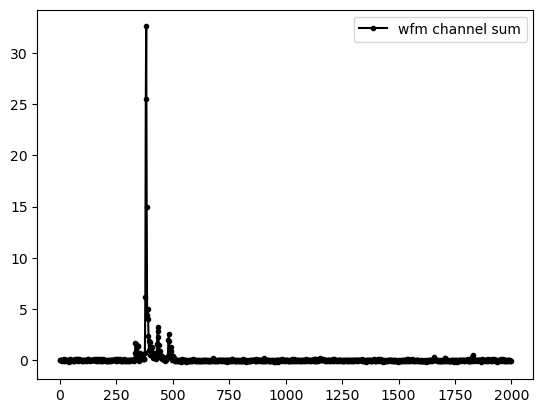

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  382   32.57071499718481
event  2833


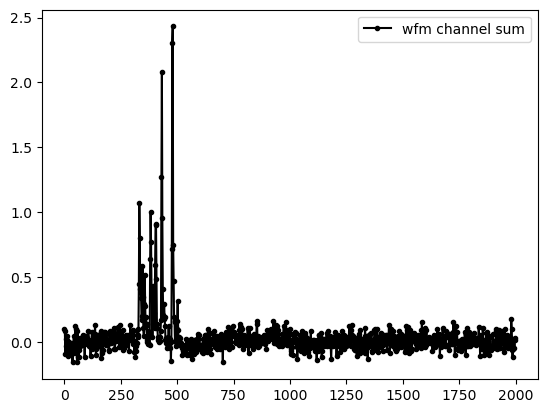

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  480   2.4315842209391714
event  2834


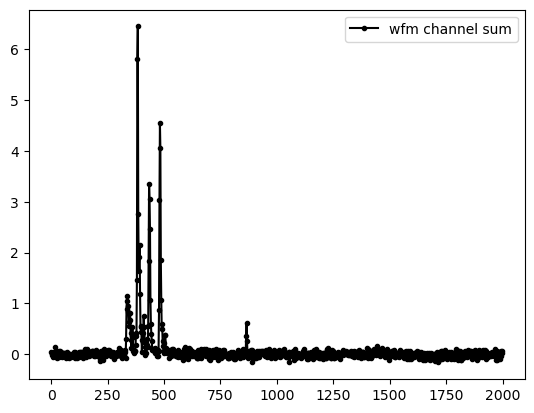

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  384   6.452571629570193
event  2835


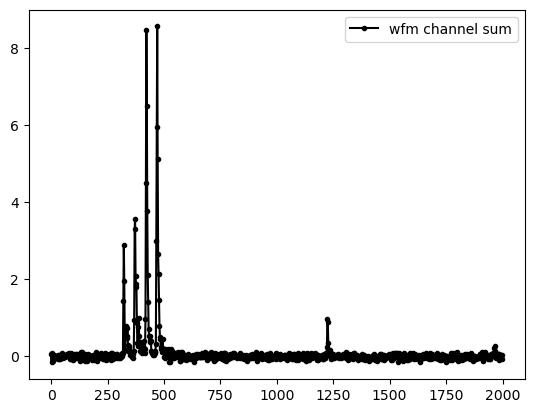

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  470   8.569355588614377
event  2836


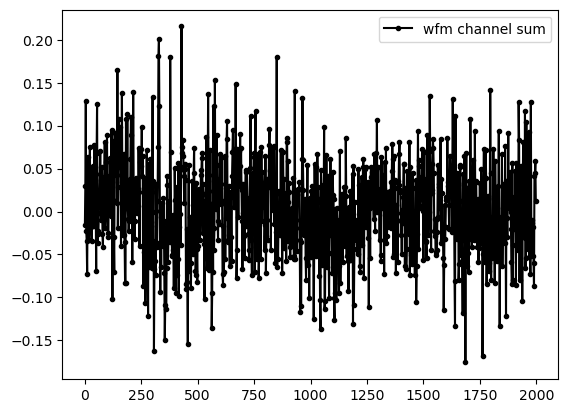

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  428   0.21544479001723363
event  2837


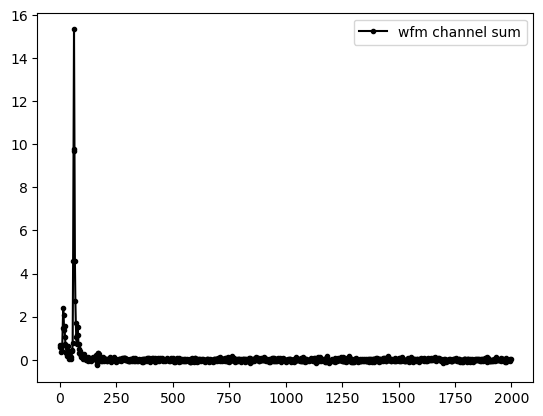

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  62   15.333523682735429
event  2838


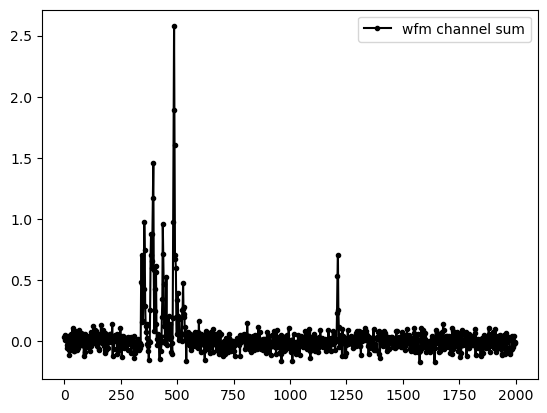

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  486   2.574290678299878
event  2839


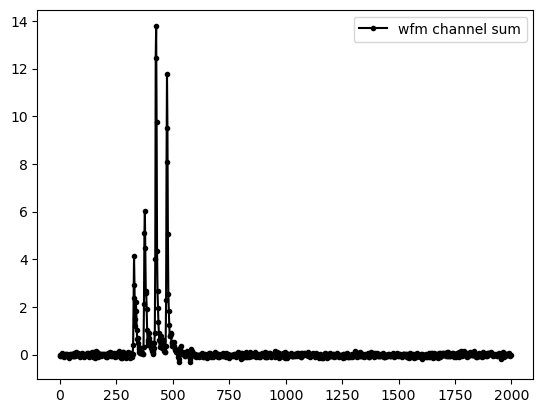

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  426   13.766541159987968
event  2840


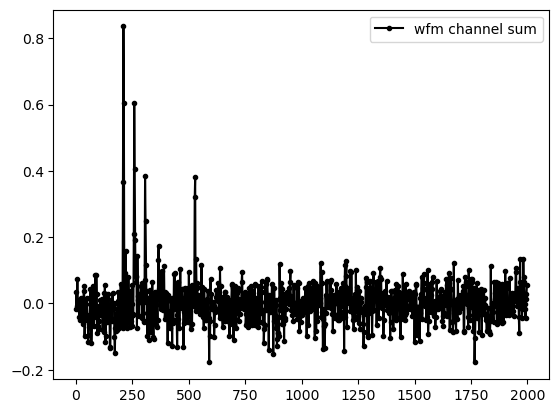

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  210   0.835597847077973
event  2841


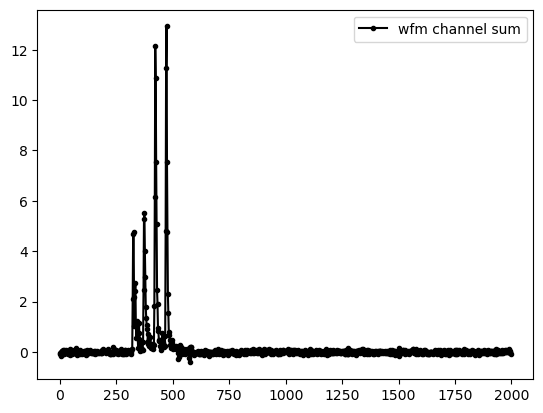

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   12.922286997570534
event  2842


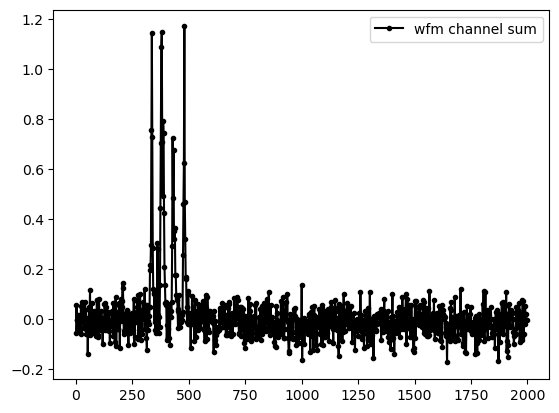

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  480   1.1704316011877234
event  2843


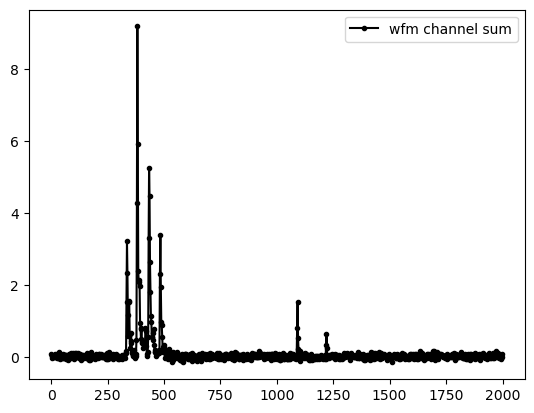

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  382   9.182042936878359
event  2844


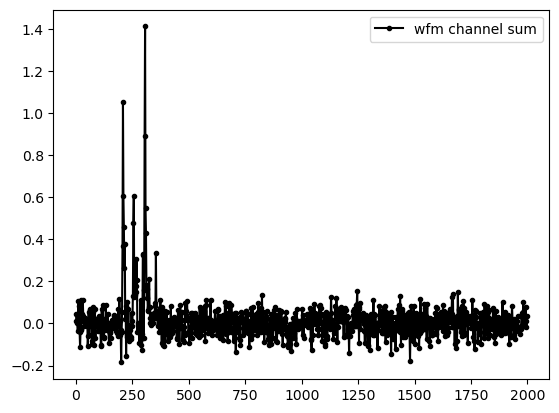

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  306   1.4107755833661697
event  2845


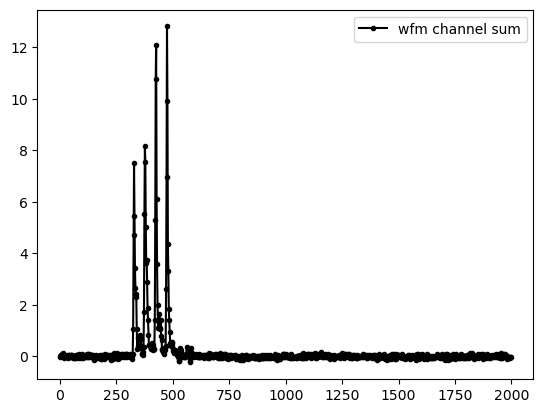

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   12.812909969963354
event  2846


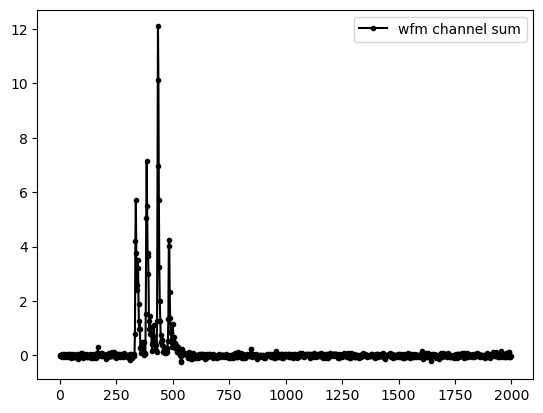

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  434   12.093716037956753
event  2847


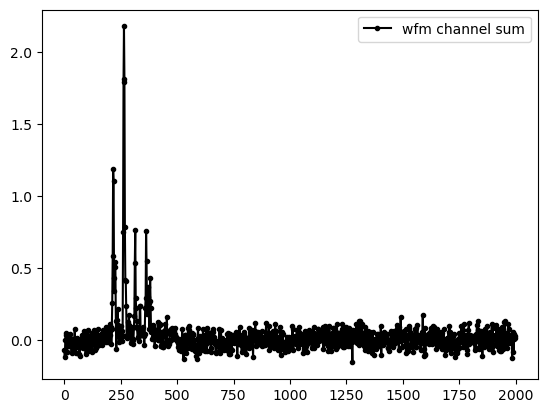

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  264   2.180406927137041
event  2848


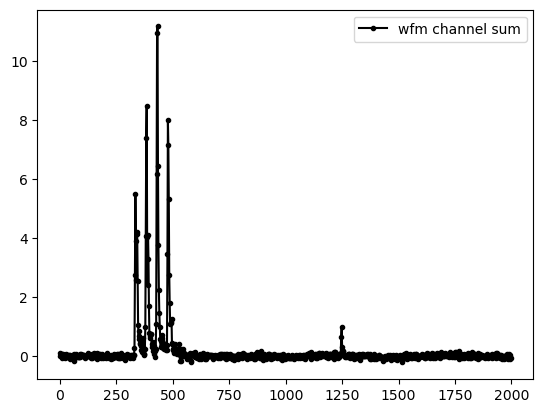

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  432   11.181876634316112
event  2849


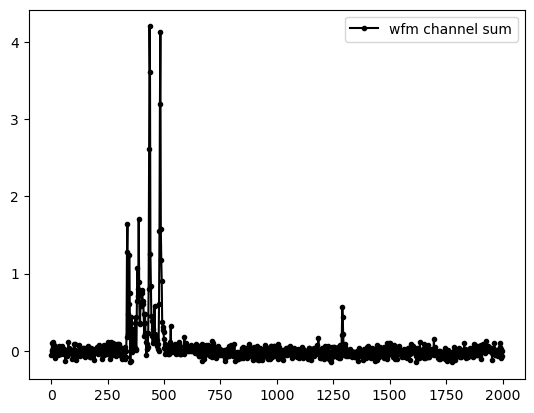

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  436   4.196704715705718
event  2850


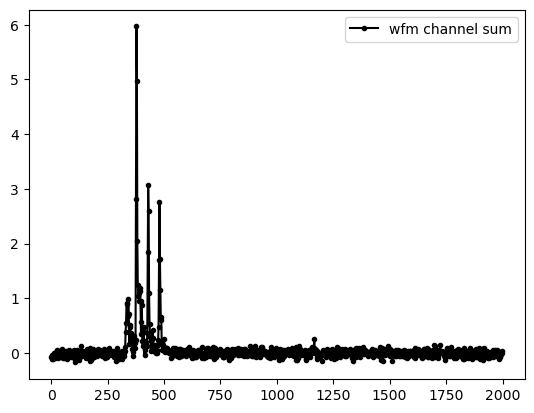

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  378   5.968864735406669
event  2851


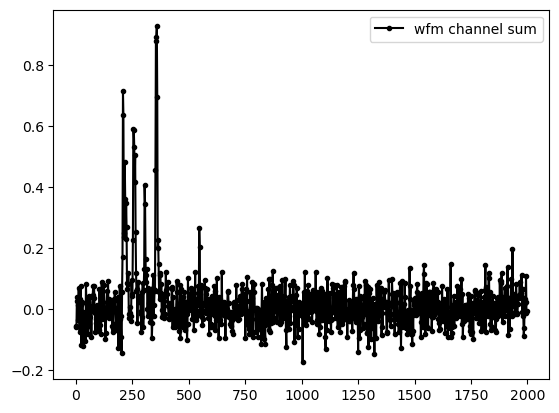

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  358   0.9272702697575397
event  2852


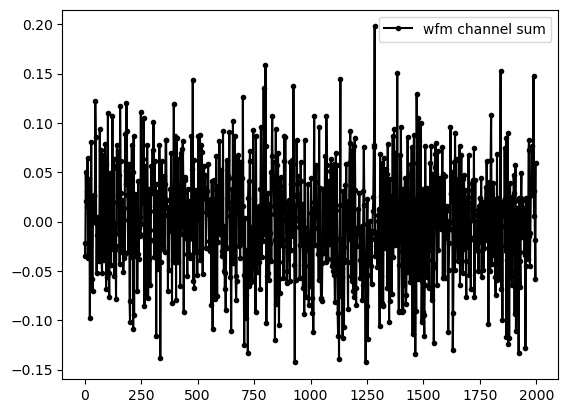

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  1284   0.1978258557626534
event  2853


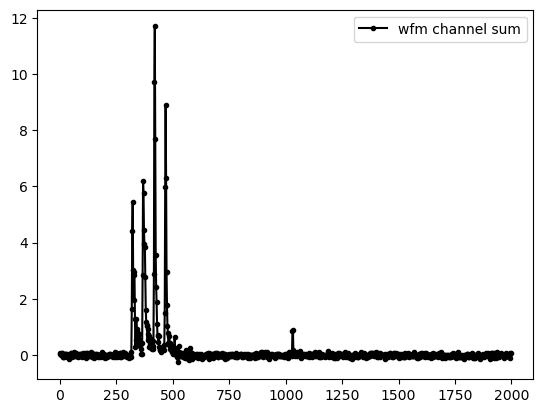

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  420   11.699300529992835
event  2854


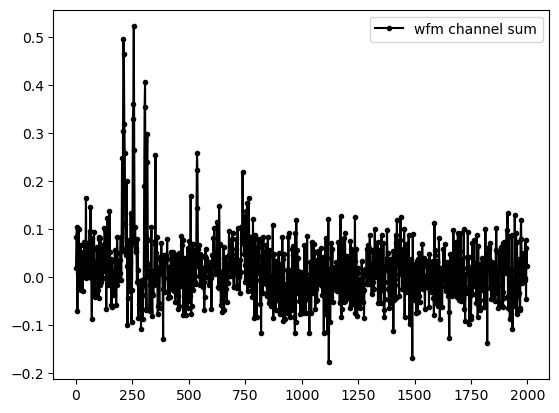

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  256   0.5212507768969845
event  2855


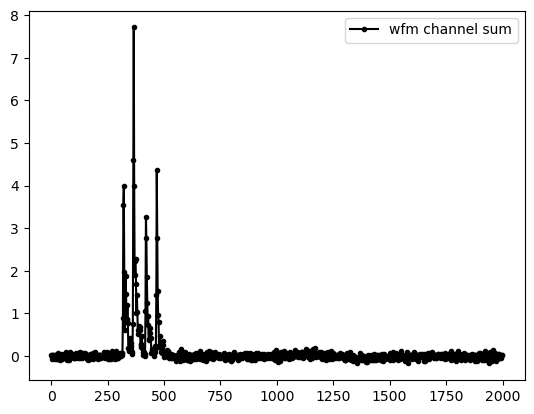

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  366   7.713626756985237
event  2856


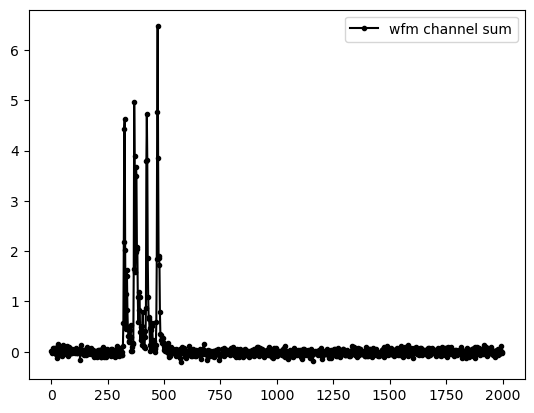

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   6.468180893786234
event  2857


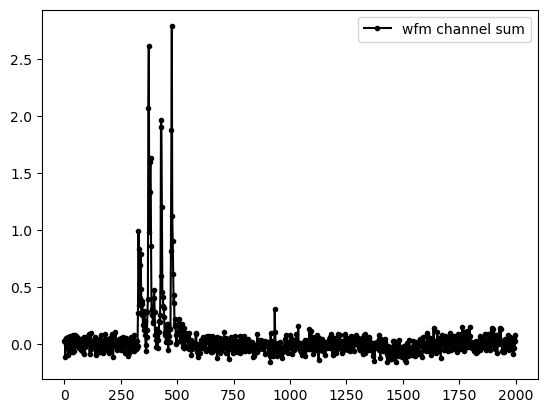

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  476   2.789281158399925
event  2858


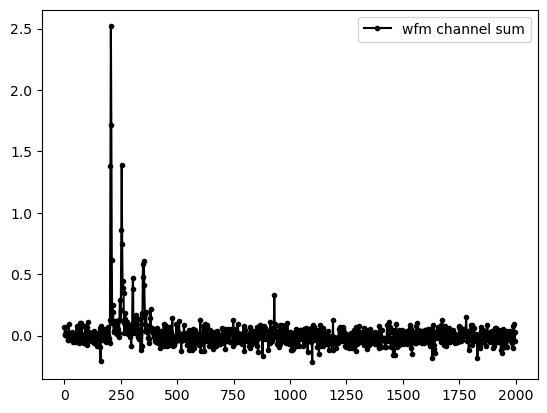

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  206   2.516797866633884
event  2859


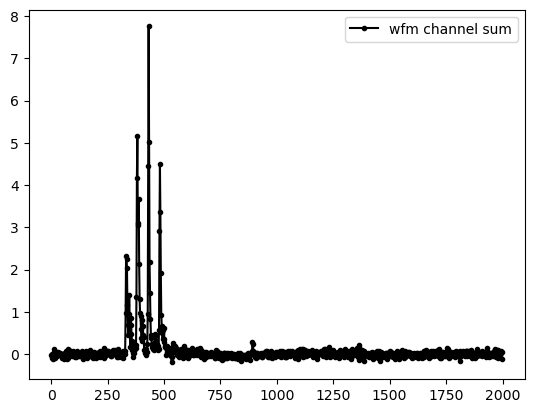

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  432   7.756483408020061
event  2860


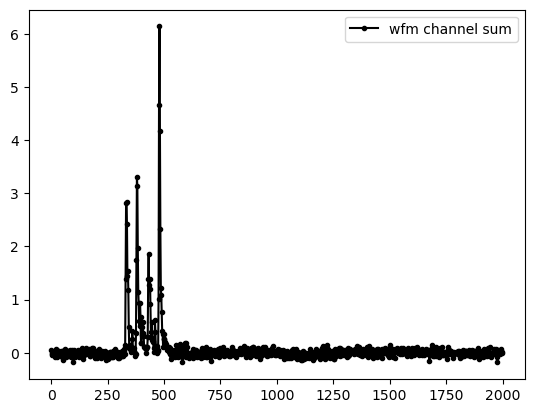

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  480   6.142364475098291
event  2861


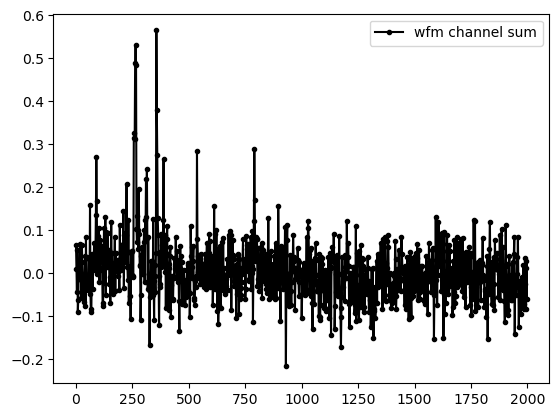

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  356   0.564899184500403
event  2862


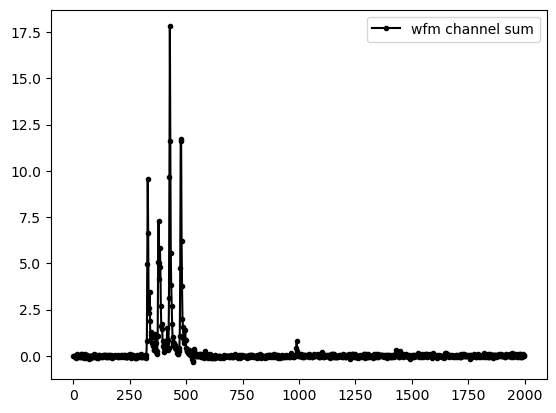

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  428   17.80477487046804
event  2863


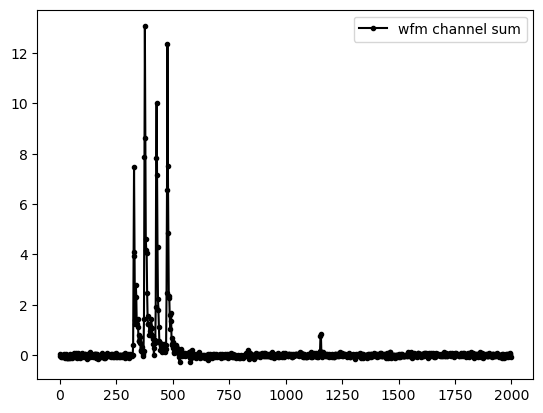

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  376   13.058911778797611
event  2864


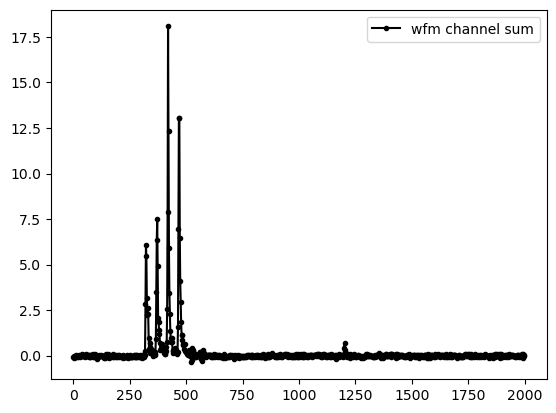

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  420   18.071118816338846
event  2865


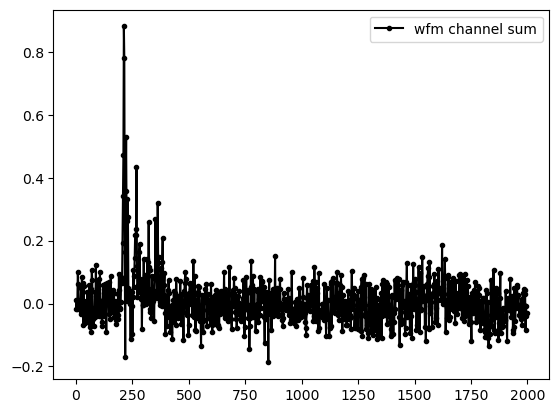

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  212   0.8812281353621517
event  2866


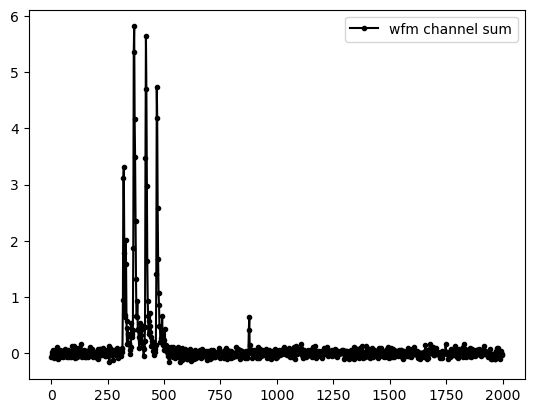

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  368   5.809538829456379
event  2867


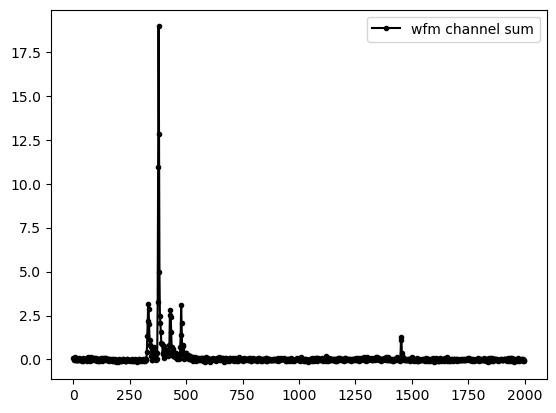

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  378   18.94340834652748
event  2868


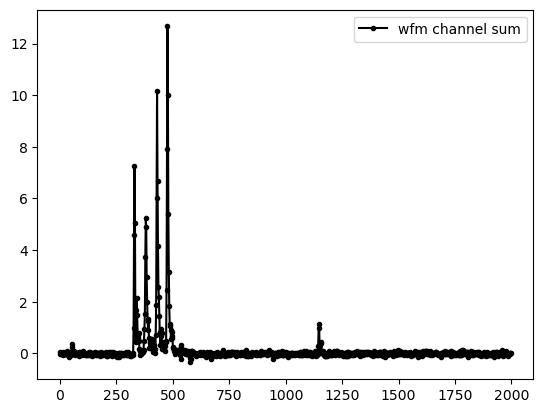

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  476   12.660779986981604
event  2869


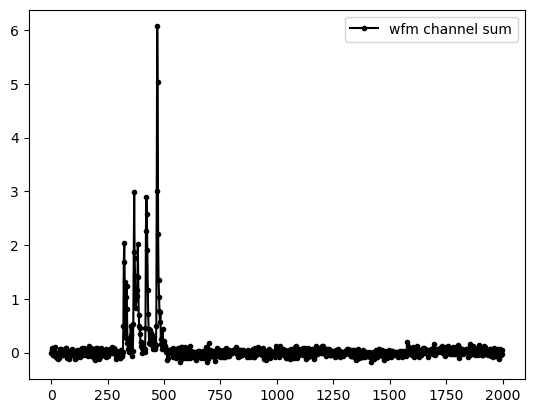

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  470   6.0689574464347
event  2870


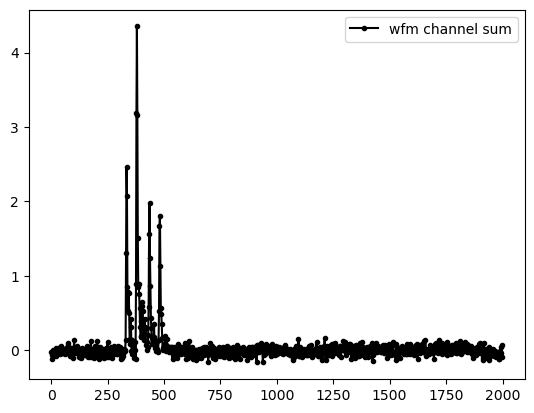

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  380   4.351737632856792
event  2871


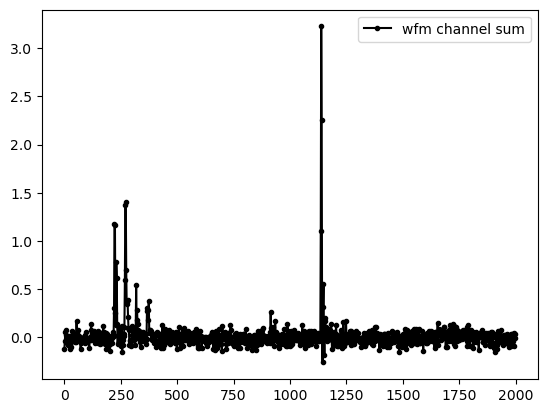

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  1138   3.2254894246283055
event  2872


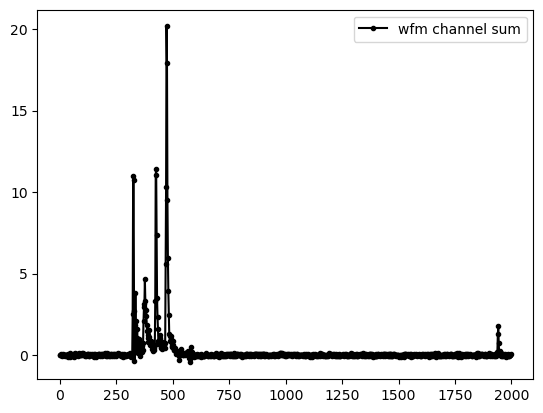

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   20.16632310913912
event  2873


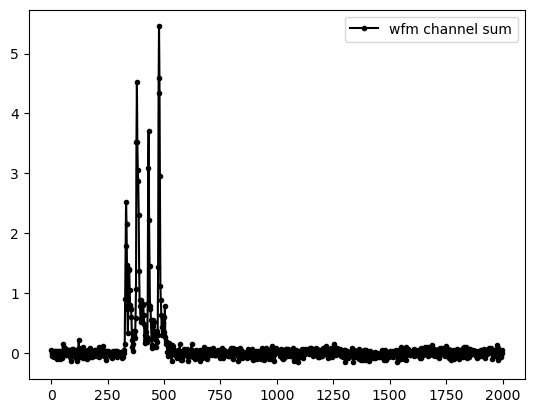

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  478   5.451037812537789
event  2874


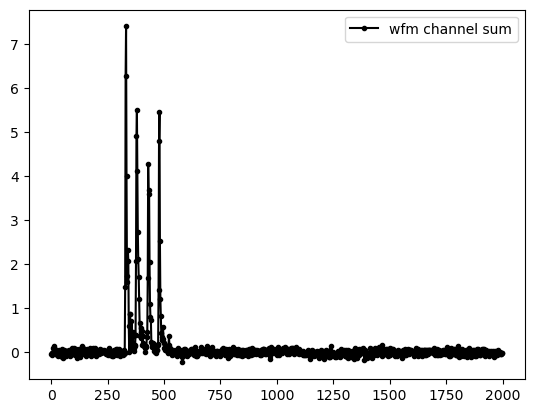

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  332   7.395985389761875
event  2875


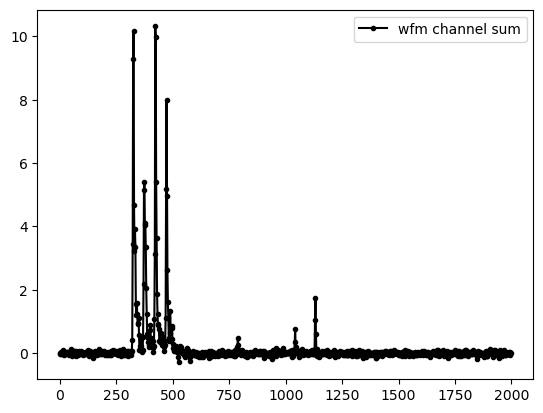

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  422   10.310504700635498
event  2876


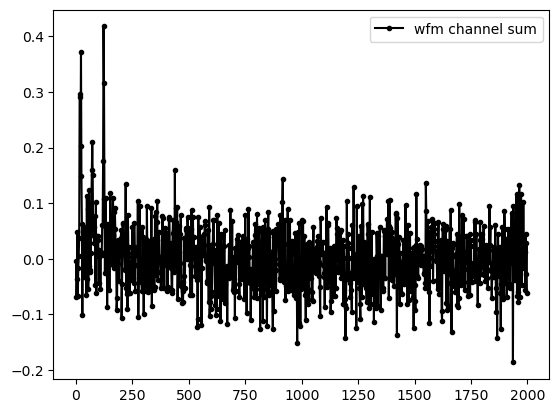

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  122   0.4179077221515778
event  2877


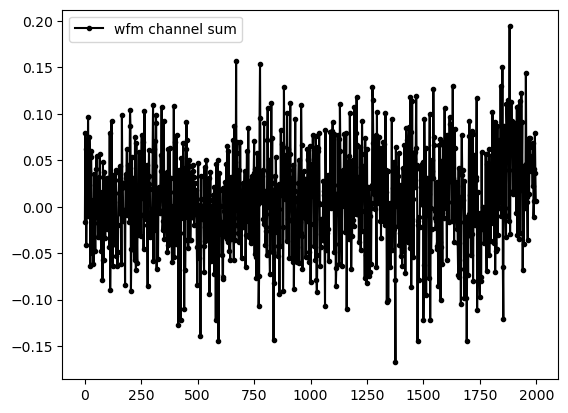

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  1882   0.19410990147452176
event  2878


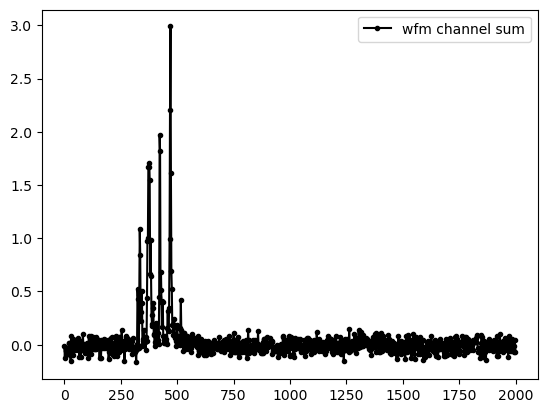

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  470   2.990512811969833
event  2879


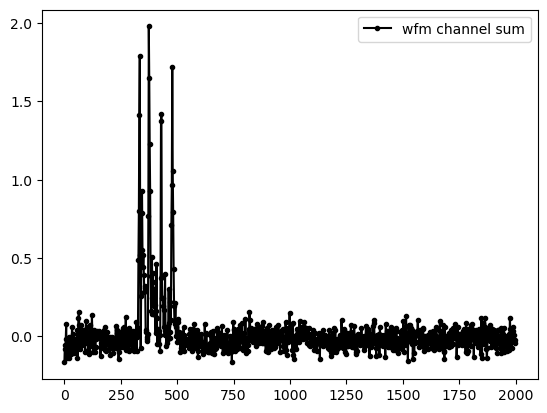

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  374   1.9778030031816598
event  2880


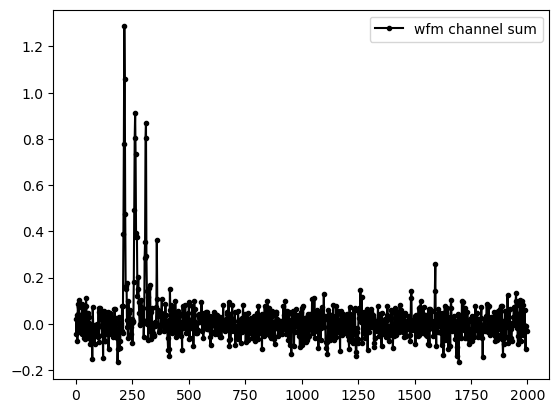

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  214   1.2863054784300738
event  2881


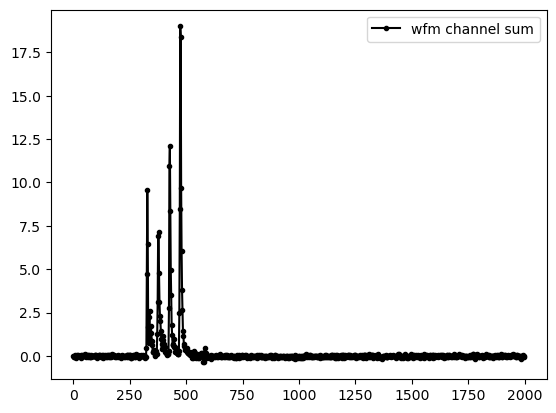

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  474   18.993796535553695
event  2882


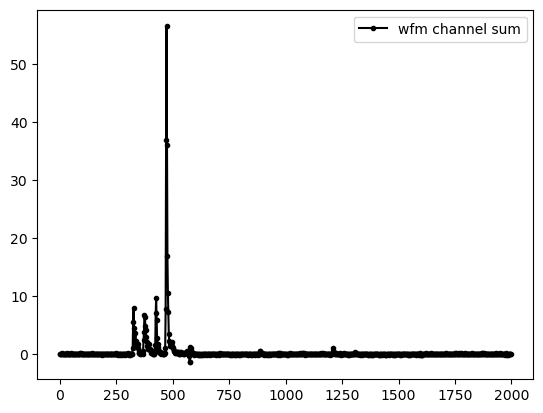

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   56.438803119926675
event  2883


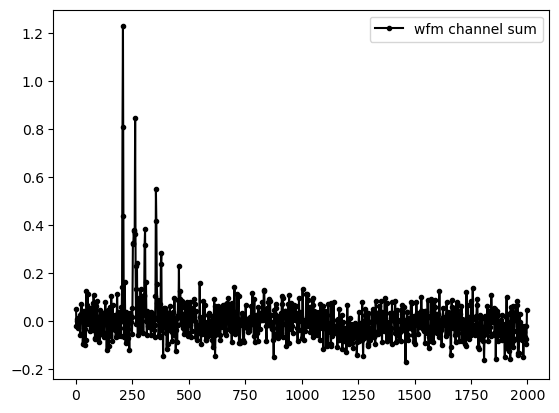

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  208   1.2280050350751797
event  2884


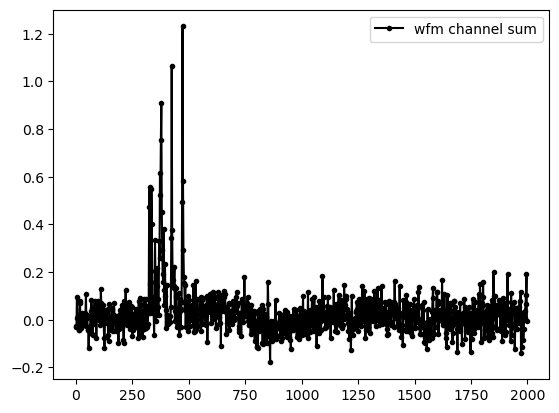

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  472   1.2305212076393266
event  2885


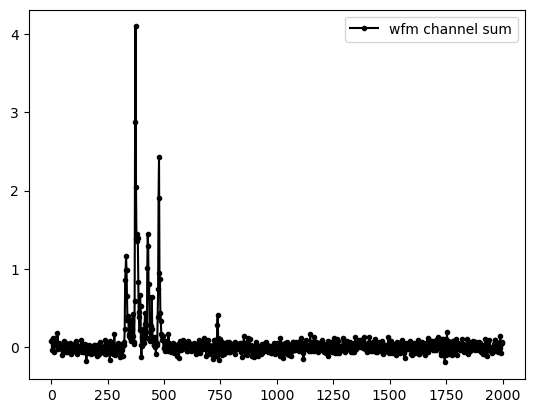

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  374   4.097365823681408
event  2886


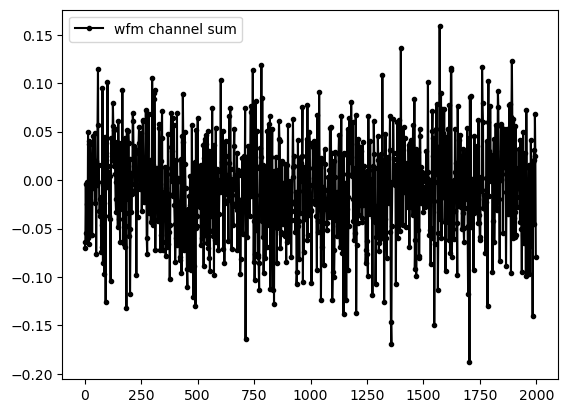

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  1572   0.1585334327347818
event  2887


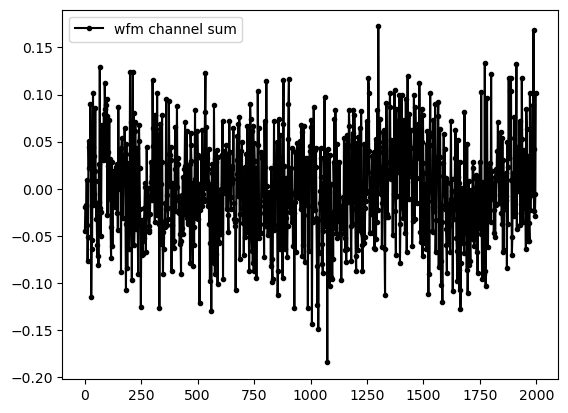

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  1300   0.17216738245372876
event  2888


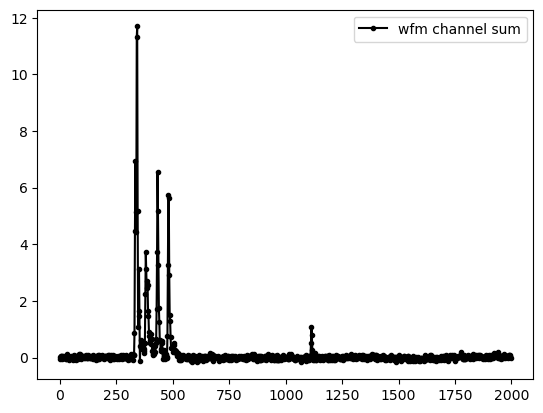

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  342   11.692711537428789
event  2889


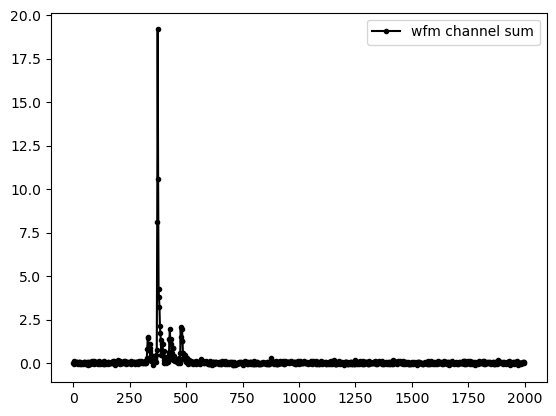

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  374   19.192207416124223
event  2890


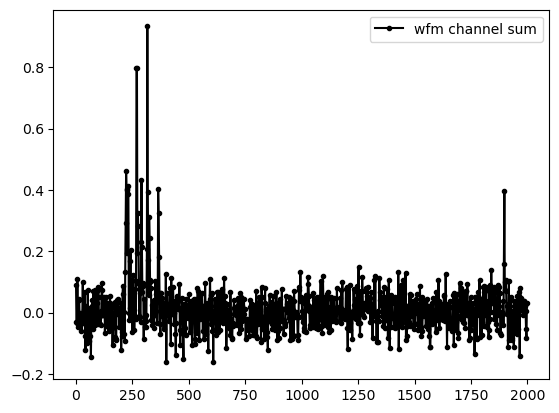

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  316   0.933271395871217
event  2891


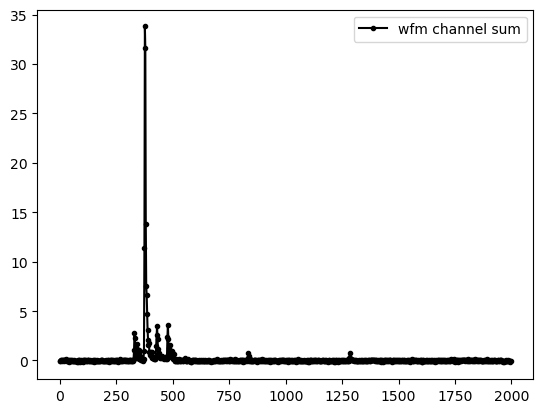

<Figure size 640x480 with 0 Axes>

max x and y (time) locations:  376   33.7946914206052
event  2892


In [ ]:
hodo5 = 0
hodo6 = 0
hodo7 = 0
top_fire = np.zeros( (10, 10) )
bot_fire = np.zeros( (10, 10) )
time_loc = []
chg_wtime = []

min_id, max_id = dp.get_bound_id()

for ievt in range(min_id, max_id):
    #[106012, 105977,
     #        105928, 105869, 105828,105703,105682,105238,
      #      105186, 105104, 105037, 104976, 104951, 104671, 104664, 104636]:
    #if ievt < 1730 and ievt > 1720:
    #    continue
    #if ievt%100 == 0:
    hodo1 = 0
    hodo2 = 0 
    hodo3 = 0
    hodo4 = 0
    top1 = []
    top2 = []
    bot1 = []
    bot2 = []
    print ("event ", ievt)
    ichn = 0
    iichn = 0
    #dp.display_waveform(ievt, 'adc_b5_ch1', baseline_subtracted=True)
    wfm = dp.get_all_waveform(ievt)
    if wfm == None:
        continue

    evt_chg=[]
    hodo_chg=[]

    for chn in ['sum']:
        t = wfm.time_axis_ns
        mask = (t>=-2000) & (t<2000)
        x_data=t[mask]
        y_data=wfm.amp_pe[chn][mask]
        
        yy_data = y_data.tolist()
        aa = yy_data.index(np.max(yy_data))

        plt.plot(x_data, y_data, color='k', marker='.', label='wfm channel {}'.format(chn))
        plt.legend()
        plt.figure()
        plt.show()

        print('max x and y (time) locations: ',aa*2, ' ', np.max(yy_data))
        time_loc.append(aa)
        chg_wtime.append(np.sum(y_data))

In [ ]:
    #for chn in [
    #            'adc_b1_ch1', 'adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4', 'adc_b1_ch5', 
    #            'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8', 'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11',
    #            'adc_b1_ch12', 'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15', 
    #            'adc_b2_ch0', 'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3', 'adc_b2_ch4', 'adc_b2_ch5', 
    #            'adc_b2_ch6', 'adc_b2_ch7','adc_b2_ch8', 'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11', 
    #            'adc_b2_ch12', 'adc_b2_ch13','adc_b2_ch14', 'adc_b2_ch14',
    #            'adc_b3_ch0', 'adc_b3_ch1', 'adc_b3_ch2', 'adc_b3_ch3', 'adc_b3_ch4', 'adc_b3_ch5', 
    #            'adc_b3_ch6', 'adc_b3_ch7', 'adc_b3_ch8', 'adc_b3_ch9', 'adc_b3_ch10', 'adc_b3_ch11',
    #            'adc_b3_ch12', 'adc_b3_ch13', 'adc_b3_ch14', 'adc_b3_ch15', 
    #            'adc_b4_ch0', 'adc_b4_ch1',
    #            'adc_b4_ch2', 'adc_b4_ch3', 'adc_b4_ch4', 'adc_b4_ch5', 'adc_b4_ch6', 'adc_b4_ch7',
    #            'adc_b4_ch8', 'adc_b4_ch9', 'adc_b4_ch10', 'adc_b4_ch11', 'adc_b4_ch11', 'adc_b4_ch13',
    #            'adc_b4_ch14', 'adc_b4_ch15', 
    #            'adc_b5_ch1', 'adc_b5_ch2', 'adc_b5_ch3', 'adc_b5_ch4', 'adc_b5_ch5', 
    #            'adc_b5_ch6', 'adc_b5_ch7', 'adc_b5_ch8', 'adc_b5_ch9', 'adc_b5_ch10', 'adc_b5_ch11',
    #            'adc_b5_ch12', 'adc_b5_ch13', 'adc_b5_ch14', 'adc_b5_ch15', 'adc_b5_ch16', 'adc_b5_ch17',
    #            'adc_b5_ch18', 'adc_b5_ch19', 'adc_b5_ch20', 'adc_b5_ch21', 'adc_b5_ch22', 'adc_b5_ch23',
    #            'adc_b5_ch24', 'adc_b5_ch25', 'adc_b5_ch26', 'adc_b5_ch27', 'adc_b5_ch28', 'adc_b5_ch29',
    #            'adc_b5_ch30', 'adc_b5_ch31', 'adc_b5_ch32', ]: 
    #for chn in ['adc_b5_ch17', 'adc_b5_ch18', 'adc_b5_ch19', 'adc_b5_ch20', 'adc_b5_ch21', 'adc_b5_ch22', 'adc_b5_ch23',
    #           'adc_b5_ch24', 'adc_b5_ch25', 'adc_b5_ch26', 'adc_b5_ch27', 'adc_b5_ch28', 'adc_b5_ch29',
    #           'adc_b5_ch30', 'adc_b5_ch31', 'adc_b5_ch32']:
    #for chn in ['sum']:
        #wfm = dp.get_waveform(ievt, chn)
        #print ("channel ",chn," int ", ichn, " sum  ",np.sum(wfm))
    #    schn[ichn].append(np.sum(wfm.amp_pe[chn]))
    #    ichn += 1
    #    if (ichn == 1 ): 
    #        continue
    #    if (ichn == 32 ): 
    #        continue
    #    if (iichn < 46+12):
    #        evt_chg.append(np.sum(wfm.amp_pe[chn]))
    #        iichn += 1
            
    for ih in range(32):
        hodo_chg.append(schn[64+ih][-1])
        
    for ih in range(8):
        if schn[64+ih][-1] > 0.5:
            hodo1 += 1
            top1.append(ih)
        if schn[64+8+ih][-1] > 0.5:
            hodo2 += 1
            top2.append(ih)
        if schn[64+16+ih][-1] > 0.5:
            hodo3 += 1
            bot1.append(ih)
        if schn[64+24+ih][-1] > 0.5:
            hodo4 += 1
            bot2.append(ih)
    if len(top1) != 0 or len(top2) != 0:
        #print ('top1 ',top1)
        #print ('top2 ',top2)
        if len(top1) == 0 and len(top2) != 0:
            for jj in range(len(top2)):
                top_fire[9][jj] += 1
        if len(top2) == 0 and len(top1) != 0:
            for ii in range(len(top1)):
                top_fire[ii][9] += 1
        if len(top2) != 0 and len(top1) != 0:
            for ii in range(len(top1)):
                for jj in range(len(top2)):
                    #print ('?? ', ii,' ',jj, ' ',top1[ii],' ', top2[jj])
                    top_fire[top1[ii]][top2[jj]] = top_fire[top1[ii]][top2[jj]]+ 1

    #print (top_fire)
    if len(bot1) != 0 or len(bot2) != 0:
        #print ('bot1 ',bot1)
        #print ('bot2 ',bot2)
        if len(bot1) == 0 and len(bot2) != 0:
            for jj in range(len(bot2)):
                bot_fire[9][jj] += 1
        if len(bot2) == 0 and len(bot1) != 0:
            for ii in range(len(bot1)):
                bot_fire[ii][9] += 1  
        if len(bot1) != 0 and len(bot2) != 0:
            for ii in range(len(bot1)):
                for jj in range(len(bot2)):
                    bot_fire[bot1[ii]][bot2[jj]] = bot_fire[bot1[ii]][bot2[jj]]+ 1
    h_hodo[0].append(hodo1)
    h_hodo[1].append(hodo2)
    h_hodo[2].append(hodo3)
    h_hodo[3].append(hodo4)
    if (hodo1 == 1 and hodo2 == 1):
        hodo5 += 1
    if (hodo3 == 1 and hodo4 == 1):
        hodo6 += 1
    if (hodo1 == 1 and hodo2 == 1 and hodo3 == 1 and hodo4 == 1):
        hodo7 += 1
        print ("::::::::::: good event ::::: ",ievt)
        #display_hodoscope(hodo_chg)
        #display_charge(evt_chg, hodo_chg)
print ("hodo 5 through 7 ", hodo5,' ',hodo6,' ',hodo7)
        

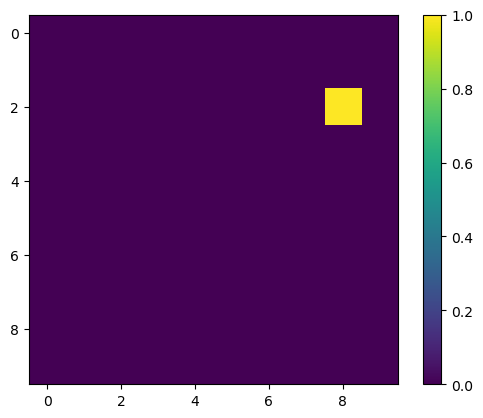

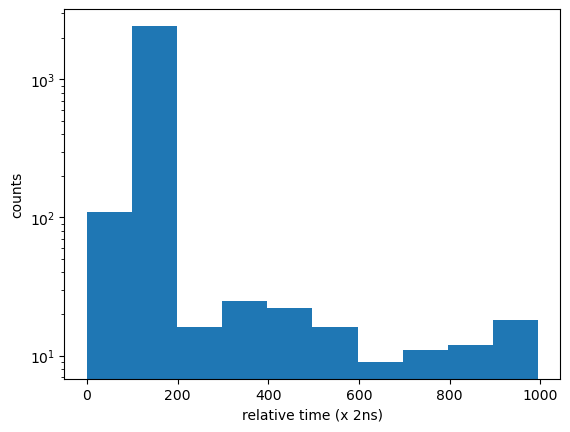

[168, 168, 113, 5, 112, 112, 165, 530, 163, 116, 169, 986, 169, 165, 111, 7, 164, 165, 115, 112, 116, 116, 0, 114, 109, 47, 163, 112, 114, 111, 170, 167, 112, 113, 169, 167, 111, 115, 170, 114, 111, 117, 114, 916, 116, 111, 116, 112, 911, 114, 166, 113, 112, 117, 165, 115, 309, 115, 169, 114, 115, 166, 111, 164, 164, 109, 113, 165, 110, 117, 118, 135, 109, 113, 115, 114, 111, 165, 115, 112, 112, 166, 116, 165, 117, 167, 114, 164, 166, 113, 159, 113, 167, 114, 108, 162, 117, 164, 166, 169, 108, 110, 163, 233, 116, 167, 112, 109, 739, 110, 168, 171, 170, 116, 113, 169, 111, 166, 162, 113, 113, 175, 112, 763, 115, 168, 167, 110, 117, 383, 114, 162, 110, 162, 110, 115, 164, 114, 850, 110, 113, 162, 165, 164, 111, 165, 110, 10, 114, 116, 115, 162, 362, 162, 114, 165, 111, 115, 166, 166, 116, 112, 165, 164, 113, 111, 168, 164, 114, 168, 108, 109, 111, 458, 165, 116, 164, 110, 165, 426, 167, 111, 110, 115, 113, 110, 165, 112, 113, 114, 890, 163, 168, 166, 160, 115, 111, 115, 112, 166, 113, 45

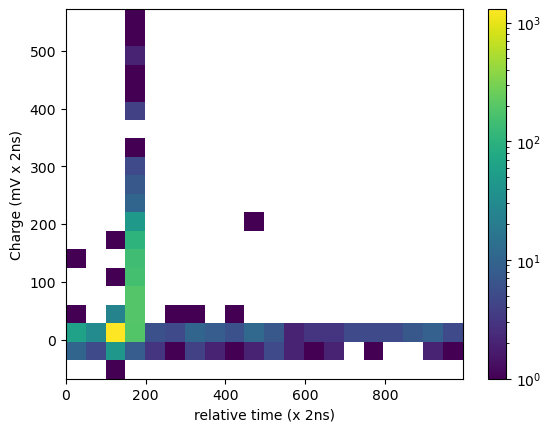

In [10]:
testA = np.zeros( (10, 10) )
testA[2][8] = 1
plt.imshow(testA)
plt.colorbar()
plt.show()

plt.hist(time_loc)
plt.ylabel("counts")
plt.xlabel("relative time (x 2ns)")
plt.yscale('log')
plt.show()

time_loc2=[]
chg_wtimee=[]
from matplotlib.colors import LogNorm
for i in range(len(chg_wtime)):
    if chg_wtime[i] < 600:
        time_loc2.append(time_loc[i])
        chg_wtimee.append(chg_wtime[i])
print(time_loc2)
print(chg_wtimee)
plt.hist2d(time_loc2, chg_wtimee, bins = 100, norm=LogNorm())
plt.ylabel("Charge (mV x 2ns)")
plt.xlabel("relative time (x 2ns)")
plt.colorbar()
plt.show()

[[3.400e+01 7.000e+00 3.200e+01 1.000e+01 3.200e+01 1.600e+01 8.000e+00
  3.800e+01 0.000e+00 4.400e+01]
 [2.860e+02 1.600e+01 2.940e+02 3.800e+01 3.680e+02 7.600e+01 3.800e+01
  3.530e+02 0.000e+00 8.000e+00]
 [9.500e+01 1.100e+01 9.500e+01 2.600e+01 1.040e+02 3.700e+01 2.500e+01
  9.400e+01 0.000e+00 1.000e+00]
 [7.200e+01 1.000e+01 7.300e+01 1.800e+01 7.600e+01 2.500e+01 2.200e+01
  6.700e+01 0.000e+00 0.000e+00]
 [1.276e+03 6.500e+01 1.279e+03 1.060e+02 1.532e+03 2.680e+02 1.160e+02
  1.459e+03 0.000e+00 0.000e+00]
 [1.990e+02 2.000e+01 2.180e+02 3.000e+01 2.640e+02 6.300e+01 4.400e+01
  2.420e+02 0.000e+00 0.000e+00]
 [4.400e+01 4.000e+00 3.700e+01 1.200e+01 5.300e+01 2.000e+01 1.600e+01
  5.300e+01 0.000e+00 0.000e+00]
 [1.900e+01 6.000e+00 1.800e+01 8.000e+00 1.900e+01 6.000e+00 3.000e+00
  1.900e+01 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [3.650e+02 3.290e+02 2.370e+02 1.080e+02 1.700e+01 1.0

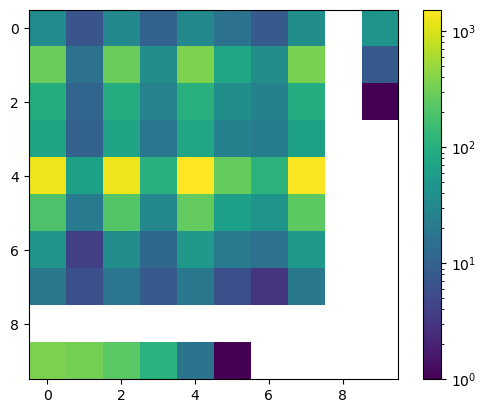

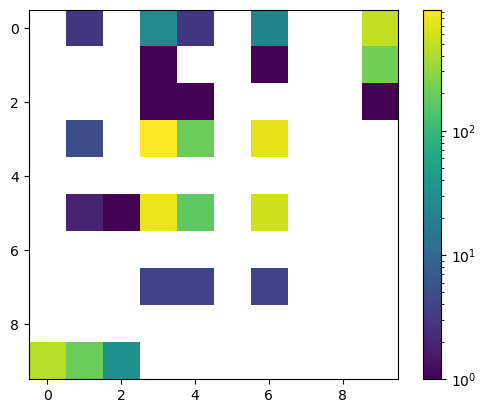

In [11]:
print(top_fire)
print(bot_fire)
print(np.shape(top_fire))

plt.imshow(top_fire, norm=colors.LogNorm())
plt.colorbar()
plt.show()

plt.imshow(bot_fire, norm=colors.LogNorm())
plt.colorbar()
plt.show()

In [ ]:
#print (schn)
#plt.figure()
f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(h_hodo[idx+0], bins=10, range=[0,10], label = "hodo. mod. {}".format(idx+1),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("Number of bars")
    ax.legend()   
plt.tight_layout()

f,a = plt.subplots(4,4)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+0], bins=50, range=[0,20], label = "chn {}".format(idx+1),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b1.png')

f,a = plt.subplots(4,4)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+16], bins=50, range=[0,20], label = "chn {}".format(idx+16),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b2.png')

f,a = plt.subplots(4,4)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+32], bins=50, range=[0,20], label = "chn {}".format(idx+32),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b3.png')

f,a = plt.subplots(4,4)
a = a.ravel()
for idx,ax in enumerate(a):
    if idx +48 == 61 or idx + 48 == 62:
        ax.hist(schn[idx+48], bins=50, range=[0,1000], label = "chn {}".format(idx+48),\
                    histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    else:
        ax.hist(schn[idx+48], bins=50, range=[0,20], label = "chn {}".format(idx+48),\
                    histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b4.png')

f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+64], bins=50, range=[0,4], label = "chn {}".format(idx+1),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b5_1.png')

f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+72], bins=50, range=[0,4], label = "chn {}".format(idx+9),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b5_2.png')

f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(schn[idx+80], bins=50, range=[0,4], label = "chn {}".format(idx+17),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b5_3.png')

f,a = plt.subplots(4,2)
a = a.ravel()
for idx,ax in enumerate(a):
    if idx + 25 == 33:
        break
    ax.hist(schn[idx+88], bins=50, range=[0,4], label = "chn {}".format(idx+25),\
                histtype='step', linewidth=2, color='c',hatch='', edgecolor='b',fill=False)
    ax.set_xlabel("mV ns")
    ax.legend()   
    ax.set_yscale("log")
plt.tight_layout()
plt.savefig('full_test_20240226_b5_4.png')

In [ ]:
# summed waveform of bottom PMTs
user_list=['adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4',
            'adc_b1_ch5', 'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8',
            'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11','adc_b1_ch12',
             'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15','adc_b2_ch0',
             'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3','adc_b2_ch4',
             'adc_b2_ch5', 'adc_b2_ch6', 'adc_b2_ch7','adc_b2_ch8',
             'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11','adc_b2_ch12',
             'adc_b2_ch13', 'adc_b2_ch14', 
            ]
dp.set_user_summed_channel_list(user_list)
dp.display_waveform(314, 'sum')

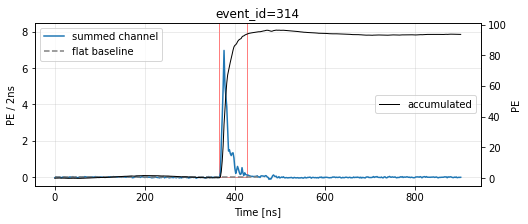

In [8]:
# summed waveform of side PMTs
user_list=[300, 301, 302, 303, 304, 305, 306, 307, 
           308, 309, 310, 311, 312, 313, 314, 315]
dp.set_user_summed_channel_list(user_list)
dp.display_waveform(314, 'sum')


## Aggregated Analysis 

In [9]:
def correct_trg_delay(adc):
    """
    3 digitizer boards are in daisy chain setup. The delay between TRG_IN and TRG_OUT is 48 ns. 
    To alogn muon pulse, we need to shift the waveform from different boards.
    
    Args:
        adc: dict
    """
    adc_corr = adc.copy()
    dT_ns = 48 # externally calibrated
    dS = dT_ns//2
    for ch, val in adc.items():
        a = np.stack(val)
        if "_b1" in ch:
            a=a[:, dS*2:]
        elif "_b2" in ch:
            a=a[:, dS:-dS]
        elif "_b3" in ch:
            a=a[:, 0:-dS*2]
        else:
            print("ERROR")
            return None
        adc_corr[ch] = a
    return adc_corr

In [10]:
'''
All 48 digitizer channels are active. Only 46 of them are used to digitize PMT signal. Two are used to digitize bottom paddles. 

We did not have SPE calibration of paddles. So we need to exclude the two paddle channels when doing the SPE normalization.
'''
BP_CH_LIST = ['adc_b1_ch0', 'adc_b2_ch15']

In [11]:

def load_data(fpath):
    """
    This function load the root file, and return the data as a dictionary.
    
    Since it loads the entire data set at once, it may take a few minutes.
    
    Args:
        fpath: str. Path to root file
    """
    f = uproot.open(fpath)
    t = f['daq']
    event_id =  t['event_id'].array(library='np')
    event_ttt =  t['event_ttt'].array(library='np')
    n_events=len(event_id)
    
    ch_names = []
    ch_id = []
    for k in t.keys():
        if k[0:4]=='adc_':
            ch_names.append(k)
            tmp = re.findall(r'\d+', k)
            ch_id.append( int(tmp[0])*100+int(tmp[1]) )
    adc =  t.arrays(ch_names, library='np')
    map_ch_name= dict(zip(ch_id, ch_names)) # from ch_id to ch_name
    
    n_samples = len(adc['adc_b1_ch1'][0])
    
    # do a simple flat baseline subtraction
    amp_mV = {}
    amp_pe = {} # unit: pe/ns
    for ch in ch_names:
        amp_mV[ch] = np.zeros([n_events, n_samples])
        for i in range(n_events):
            amp_mV[ch][i] = (np.median(adc[ch][i])-adc[ch][i])*ADC_TO_MV
        if ch in BP_CH_LIST:
            continue
        amp_pe[ch] = np.zeros([n_events, n_samples])
        for i in range(n_events):
            amp_pe[ch][i] = amp_mV[ch][i]/SAMPLE_TO_NS/50/1.6
    
    amp_mV = correct_trg_delay(amp_mV)
    amp_pe = correct_trg_delay(amp_pe)
    
    return dict(
        n_events=n_events,
        n_samples=n_samples,
        event_id=event_id,
        event_ttt=event_ttt,
        ch_names = ch_names,
        ch_id = ch_id,
        amp_mV = amp_mV,
        amp_pe = amp_pe,
    )

data = load_data(fpath)

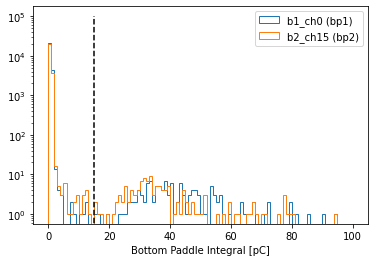

In [12]:
"""
Let's take a look at the area of the two paddles. The area is just integral 
over the entire waveform. Then we convert its unit to charge [pC] (50 Ohm input 
resistance assumed)

Note:
    Since data is a dictionary, you can access its variable via key word. 
Since amp_mV variable is another dictionary, you can access channel via key word
"""
amp_bp1 = data['amp_mV']['adc_b1_ch0'] # bottom paddle 1 baseline subtracted waveform
amp_bp2 = data['amp_mV']['adc_b2_ch15'] # bottom paddle 2 baseline subtracted waveform
area_bp1 = np.sum(amp_bp1, axis=1)*2/50 # unit: pC
area_bp2 = np.sum(amp_bp2, axis=1)*2/50 # unit: pC
plt.figure()
plt.hist(area_bp1, bins=100, range=(0, 100), histtype='step', label='b1_ch0 (bp1)');
plt.hist(area_bp2, bins=100, range=(0, 100), histtype='step', label='b2_ch15 (bp2)');
plt.xlabel('Bottom Paddle Integral [pC]')
plt.legend()
plt.yscale('log')
plt.vlines(15, 0, 1e5, linestyle='--', color='k')
plt.show()

In [15]:
"""
Make a selection of muon passing through bottom paddles
"""
cut_pC=15 # 15pC
print('num of muons through bp1:', len(area_bp1[area_bp1>cut_pC]))
print('num of muons through bp2:', len(area_bp2[area_bp2>cut_pC]))

mask = np.logical_or(area_bp1>cut_pC,  area_bp2>cut_pC)
event_id_selected = data['event_id'][mask]
print("the following muon pass through bot pad:\n", event_id_selected)

num of muons through bp1: 132
num of muons through bp2: 136
the following muon pass through bot pad:
 [  209   406   664   767   848  1024  1243  1299  1376  1410  1444  1465
  1782  2475  2604  2726  2755  2863  2951  3428  3480  3583  3626  3925
  4119  4129  4233  4495  4824  4895  4943  4991  5000  5186  5370  5578
  5673  5788  5828  6335  6498  6566  6640  6964  7046  7284  7411  7658
  7714  7810  8578  8808  8905  8983  9063  9293  9462  9711  9793  9799
  9825  9894  9928 10254 10398 10491 10586 10797 10984 11033 11080 11257
 11334 11450 11746 12533 13131 13205 13347 14503 14637 14856 14945 14018
 14196 15256 15498 15571 16614 16618 16942 16302 17093 17146 17157 17680
 17922 18440 18513 18665 18682 18723 18210 18399 19047 19286 19475 19942
 20616 20958 20043 20340 20444 21204 21369 21423 21600 21724 21867 21999
 22950 23037 23139 23310 23452 23531 23546 23589 23921 24692 24248 24339
 24429 25501 26627 26007 26379 26441 27048 27184 27498 27727 27999 28779
 28930 28965 28194 282

In [16]:
BT_PMT_LIST=['adc_b1_ch1', 'adc_b1_ch2', 'adc_b1_ch3', 'adc_b1_ch4',
            'adc_b1_ch5', 'adc_b1_ch6', 'adc_b1_ch7', 'adc_b1_ch8',
            'adc_b1_ch9', 'adc_b1_ch10', 'adc_b1_ch11','adc_b1_ch12',
             'adc_b1_ch13', 'adc_b1_ch14', 'adc_b1_ch15','adc_b2_ch0',
             'adc_b2_ch1', 'adc_b2_ch2', 'adc_b2_ch3','adc_b2_ch4',
             'adc_b2_ch5', 'adc_b2_ch6', 'adc_b2_ch7','adc_b2_ch8',
             'adc_b2_ch9', 'adc_b2_ch10', 'adc_b2_ch11','adc_b2_ch12',
             'adc_b2_ch13', 'adc_b2_ch14', 
            ]


def calc_rq_vars(data, BP_CH_LIST=['adc_b1_ch0', 'adc_b2_ch15'], n_events=10000):
    """
    RQ stands for reduced quality. High level variables extracted from waveform.

    Args:
        data: dict. Same data returned by load_data function above.
        BP_CH_LIST: list, bottom paddle channels
        n_events: int, number of events to process

    return: 
        dict
    """
    max_n_events = data['n_events']
    n_samples = data['n_samples']
    if n_events<=0 or n_events>max_n_events:
        n_events=max_n_events
        
    pT_ns=np.zeros(n_events) # peak time
    peak_pe=np.zeros(n_events)
    npe=np.zeros(n_events) # num of pe
    npe_bt=np.zeros(n_events) # num of pe for bt
    npe_side=np.zeros(n_events)
    sba = np.zeros(n_events)
    bp1_area_pC = np.zeros(n_events)
    bp2_area_pC = np.zeros(n_events)
    for i in range(n_events):
        if i % (n_events//10) ==0:
            print("processing ", i)
        amp_sum_pe =0
        amp_bt_pe = 0
        amp_side_pe = 0
        for ch in data['ch_names']:
            if ch in BP_CH_LIST:
                continue
            amp_sum_pe += data['amp_pe'][ch][i]
            if ch in BT_PMT_LIST:
                amp_bt_pe += data['amp_pe'][ch][i]
            else:
                amp_side_pe+= data['amp_pe'][ch][i]
        idx = np.argmax(amp_sum_pe)
        pT_ns[i] = idx*2
        npe[i] = np.sum(amp_sum_pe[160:250])*2
        npe_bt[i] = np.sum(amp_bt_pe[160:250])*2
        npe_side[i] = np.sum(amp_side_pe[160:250])*2
        if (npe_side[i]+npe_bt[i])==0:
            sba[i]=None
        else:
            sba[i] = (npe_side[i]-npe_bt[i])/(npe_side[i]+npe_bt[i])
        peak_pe[i] = np.max(amp_sum_pe[160:250])
        
        bp1_area_pC[i] = np.sum(data['amp_mV']['adc_b1_ch0'][i])*2/50
        bp2_area_pC[i] = np.sum(data['amp_mV']['adc_b2_ch15'][i])*2/50

    return dict(
        npe=npe, # number of total PE by all channels
        npe_bt=npe_bt, # num. of PE from bottom PMTs
        npe_side=npe_side, # num. of PE from side PMTs
        pT_ns=pT_ns, # peak time of summed waveform in ns
        peak_pe=peak_pe,# peak height of summed waveform in pe/2ns
        sba=sba, # side-bottom asymmetry: (npe_side-npe_bt)/npe
        bp1_area_pC=bp1_area_pC, # bot paddle 1 area, unit pC
        bp2_area_pC=bp2_area_pC # bot paddle 2 area, unit pC
    )

rq = calc_rq_vars(data, n_events=100000)

processing  0
processing  5139
processing  10278
processing  15417
processing  20556
processing  25695
processing  30834
processing  35973
processing  41112
processing  46251
processing  51390


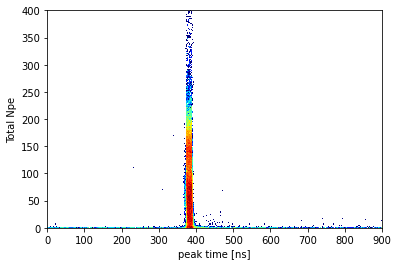

In [17]:
"""
Once you have RQ, making more plots ...
"""

plt.figure()
plt.hist2d(rq['pT_ns'], rq['npe'], bins=[450, 200], range=((0, 900), (0, 400)), 
                                                   norm=colors.LogNorm(), cmap='jet');
plt.xlabel('peak time [ns]')
plt.ylabel('Total Npe')
plt.show()

In [19]:
"""
mask just means selection; it's an array of bool, can be used to select a variable

Create several mask

- muon_mask = events whose peak time fall within the expected muon region. See the 2D plot above.
- bp_mask = events which produce signals in bottom paddles (see bottom paddle integral plot)
"""
muon_mask = (rq['pT_ns']>=360) & (rq['pT_ns']<400)

bp_mask = np.logical_or(rq['bp1_area_pC']>15, rq['bp2_area_pC']>15) # we actually defined this mask before. 

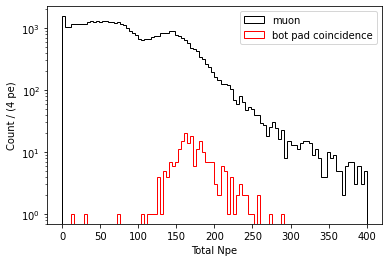

In [20]:
plt.figure()
plt.hist(rq['npe'][muon_mask], bins=100, range=(0, 400), histtype='step', color='black', label='muon');
plt.hist(rq['npe'][bp_mask], bins=100, range=(0, 400), histtype='step', color='red', label='bot pad coincidence');

plt.xlabel('Total Npe')
plt.ylabel('Count / (4 pe)')
plt.yscale('log')
plt.legend()
plt.show()

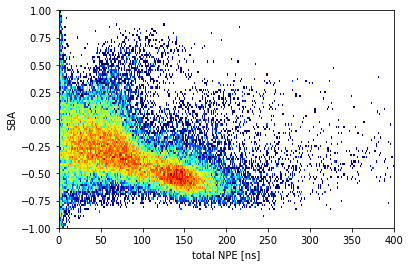

In [21]:
plt.figure()
plt.hist2d(rq['npe'][muon_mask],rq['sba'][muon_mask],  
           bins=[300, 100], range=((0, 400), (-1, 1)), 
            norm=colors.LogNorm(), cmap='jet');
plt.xlabel('total NPE [ns]')
plt.ylabel('SBA')
plt.show()

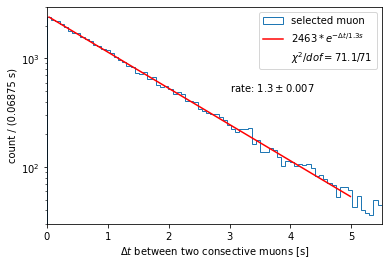

In [22]:
"""
Get event time stamp, select muons, and compute time difference 
between two consective muon
"""
muon_t = data['event_ttt'][muon_mask]*8e-9
dt = muon_t[1:]-muon_t[:-1]


plt.figure()
h = plt.hist(dt, bins=80, range=(0, 5.5), histtype='step', label='selected muon');
plt.yscale('log')
plt.xlabel(r'$\Delta t$ between two consective muons [s]')
plt.ylabel('count / (0.06875 s)')


"""
Do an exponential fit
"""
from scipy.optimize import curve_fit

def expo(x, tau, A):
    return A*np.exp(-x/tau)

def calc_chi2(func, xdata, ydata, popt):
    y = func(xdata, popt[0], popt[1])
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)

ydata = h[0]
xdata = (h[1][1:]+h[1][:-1])/2
fit_mask = (xdata>0.0) & (xdata<5)
sigma = np.sqrt(ydata[fit_mask])
popt, pcov = curve_fit(expo, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=(1.2, data['n_events']))
x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
y = expo(x, popt[0], popt[1])

chi2 = calc_chi2(expo, xdata[fit_mask], ydata[fit_mask], popt)
dof = len(xdata[fit_mask])-2
plt.plot(x, y, color='red', label='$%d*e^{-\Delta t / %.1f s}$' % (popt[1], popt[0]))
plt.xlim([0, 5.5])
plt.ylim([30, 3e3])

plt.plot([0,0], [0, 0], color='white', label='$\chi^2/dof=%.1f/%d$'%(chi2, dof))
err = np.diag(pcov)
err = np.sqrt(err)
plt.text(3, 500, r'rate: $%.1f \pm %.3f$' % (popt[0], err[0]))
plt.legend()

plt.show()

# Below are extra stuff not fully tested yet

In [ ]:
def get_freq_spectrum(a):
    sample_rate=500e6 # 500MHz
    n_samples = len(a)
    duration = n_samples/sample_rate
    a=a-np.mean(a)
    yf = rfft(a)
    xf = rfftfreq(n_samples, 1 / sample_rate)
    return xf, yf
    

def get_avg_freq_per_time_slice(adc_b2_ch1, event_id):
    
    trg_rate= 1
    sample_rate=500e6 # 500MHz
    
    dt = (event_id-event_id.min())/trg_rate
    
    n_avg = 50000
    yf_avg = []
    xf_avg = []
    dt_h = []
    n_events = len(event_id)
#     n_events=10000
    for i in range(len(event_id)):
        xf, yf = get_freq_spectrum(adc_b2_ch1[i])
        if i % n_avg == 0:
            if i == 0:
                y_avg = yf
            else:
                yf = yf/n_avg
                yf_avg.append(y_avg)
                xf_avg.append(xf)
                dt_h.append(dt[i])
                y_avg = yf
        else:
            y_avg += yf
            
    dt_l = np.array(dt_h) - (dt[n_avg]-dt[0])
    return dt_l, np.array(xf_avg), np.array(yf_avg)

def get_avg_freq_per_run(data, chName='adc_b1_ch14', n_events=1000):
    
    if n_events<=0 or n_events>data['n_events']:
        n_events=data['n_events']
    
    amp = data['amp_mV'][chName]
    yf_avg = []
    xf_avg = []
    for i in range(n_events):
        xf, yf = get_freq_spectrum(amp[i])
        if i == 0:
            y_avg = yf
        else:
            y_avg += yf
    y_avg = y_avg/n_events
    yf_avg.append(y_avg)
    xf_avg.append(xf)
    return np.array(xf_avg), np.array(yf_avg)

In [ ]:
xf, yf = get_avg_freq_per_run(data, chName="adc_b1_ch14", n_events=100)

In [ ]:


plt.plot(xf[1:], np.abs(yf[1:]))
plt.yscale('log')
plt.xlim([1/(500*2*1e-9), 3e8])
# plt.ylim([0, 6.5e6])

plt.xlabel('Freq [Hz]')
plt.ylabel('ADC (abs)')
plt.title('LED Off Run (June 15 2022); b3p1', fontsize=14);
plt.show()